# Analysis of SHEMAT-Suite models

The created geological models with gempy were exported as SHEMAT-Suite input files. SHEMAT-Suite (https://git.rwth-aachen.de/SHEMAT-Suite/SHEMAT-Suite-open) [1] is a code for solving coupled heat transport in porous media. It is written in fortran and uses a finite differences scheme in a hexahedral grid.

In this example, we will load a heat transport simulation from the base POC model we created in "Geological model creation and gravity simulation". We will demonstrate methods contained in OpenWF for loading the result file, displaying the parameters it contains and how to visualize these parameters. Finally, we will calculate the conductive heat flow and plot it.

In [1]:
# import some libraries
from scipy.stats import hmean
import pandas as pd
import numpy as np
import glob
import h5py
import os, sys
sys.path.append('../../')
import OpenWF.postprocessing as pp

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

import seaborn as sns
sns.set_style('ticks')
sns.set_context('talk')

Simulation results from SHEMAT-Suite can be written in different file formats, such as VTK (Visualization Toolkit) HDF5 (Hierarchical Data Format), or PLT (TecPlot). In addition, optional outputs, such as ASCII-Files with comparison of simulated values to measured ones can be provided. Further, a status log of the simulation and other meta-files. A full coverage of possible output files is provided in the SHEMAT-Suite wiki ( https://git.rwth-aachen.de/SHEMAT-Suite/SHEMAT-Suite-open/-/wikis/home). 
In this tutorial, we will work with HDF5 files and VTK files. The majority of methods in OpenWF are tailored towards HDF5 files, which are smaller than their VTK relatives.

However, there exists a powerful visualization code for python which builds upon vtk, called pyvista. We will briefly showcase its capabilities at the end of this tutorial.

## Load HDF5 file
From the base POC model, we created a SHEMAT-Suite input file. This was then executed with the compiled SHEMAT-Suite code. As basic information: we look at conductive heat transport, i.e. no fluid flow, and heat transport is described by Fourier's law of heat conduction $q = - \lambda \nabla T$. At the base of the model, the heat flow boundary condition is set to 72 mW/m$^2$.

OpenWF has a built in method for loading HDF5 files, though reading a file is a one-liner using the library ``h5py``. 
```python 
fid = h5py.File('../../models/SHEMAT-Suite_output/SHEMAT_PCT_base_model_final.h5')
```
The file can be loaded in different states, among others for 'r' for read, 'a' for append, 'w' for write, etc. The ``read_hdf`` method in OpenWF lets the user also choose the state to load the HDF5 file.

In [2]:
fid = pp.read_hdf_file('../../models/SHEMAT-Suite_output/SHEMAT_PCT_base_model_temp_final.h5', write=False)

To check the parameters stored in the HDF5 file, you can query the loaded h5py file for its keys, i.e. the "labels" of the data boxes stored in the HDF5 file.

In [3]:
fid.keys()

<KeysViewHDF5 ['comp', 'delx', 'dely', 'delz', 'df', 'ec', 'head', 'itemp_bcd', 'itemp_bcn', 'kx', 'ky', 'kz', 'lc', 'lx', 'ly', 'lz', 'por', 'pres', 'q', 'rc', 'rhof', 'temp', 'temp_bcd', 'temp_bcn', 'uindex', 'visf', 'vx', 'vy', 'vz', 'x', 'y', 'z']>

As some of these acronyms can have no meaning to new users, we implemented a method, specifically for SHEMAT-Suite generated HDF5 files to present information about the stored parameters:

In [5]:
pp.available_parameters(fid)

{'comp': 'compressibility',
 'delx': 'discretization in x direction in meter',
 'dely': 'discretization in y direction in meter',
 'delz': 'discretization in z direction in meter',
 'df': '?',
 'ec': '?',
 'head': 'hydraulic potential in meter',
 'itemp_bcd': '?',
 'itemp_bcn': '?',
 'kx': 'log-permeability (square meter) in x direction',
 'ky': 'log-permeability (square meter) in y direction',
 'kz': 'log-permeability (square meter) in z direction',
 'lc': '?',
 'lx': 'thermal conductivity in x direction in watt per meter and kelvin',
 'ly': 'thermal conductivity in y direction in watt per meter and kelvin',
 'lz': 'thermal conductivity in z direction in watt per meter and kelvin',
 'por': 'porosity',
 'pres': 'pressure in megapascal',
 'q': '?',
 'rc': '?',
 'rhof': 'density water in kilogram per cubic meter',
 'temp': 'temperature in degrees celsius',
 'temp_bcd': 'temperature dirichlet boundary condition in degrees celsius',
 'temp_bcn': 'temperature neumann boundary condition in d

### Used functions

In [30]:
def read_hdf_file(filepath: str=".", write: bool=False):
    """Short method to load an hdf5 file.

    Args:
        filepath (string): path to the stored .h5 file
    """
    model_fid = h5py.File(filepath, 'r')
    
    if write==True:
        model_fid = h5py.File(filepath, 'r+')

    return model_fid

def plot_slice(file, parameter: str='temp', direction: str='x', cell_number: int=0, z_extent: float=6000.):
    if type(file)==str:
        f = read_hdf_file(file)
    else:
        f = file
        
    try:
        param = f[parameter][:,:,:]
    except KeyError:
        print(f"Unable to open {parameter}. Does not exist in HDF5 File. See method 'available_parameters' for existing parameters.")
    
    uindex = f['uindex'][:,:,:]
    x = f['x'][0,0,:]
    y = f['y'][0,:,0]
    z = f['z'][:,0,0]
    zasl = z - z_extent
    
    if direction=='x':
        pa_cs = param[:,:,cell_number]
        ui_cs = uindex[:,:,cell_number]
        
        cs = plt.contourf(y,z-z_extent,pa_cs,23,cmap='viridis')
        plt.contour(y,z-z_extent,ui_cs, colors='#222222')
        plt.title(f'{parameter},x-direction, cell {cell_number}', fontsize=16)
        plt.tick_params(axis='both',labelsize=14)
        plt.xlabel('x [m]',fontsize=16)
        plt.ylabel('depth[m]',fontsize=16)
        cbar = plt.colorbar(cs,orientation='vertical')
        cbar.set_label(f'{parameter}',fontsize=16)
        cbar.ax.tick_params(labelsize=14)
    
    elif direction=='y':
        pa_cs = param[:,cell_number,:]
        ui_cs = uindex[:,cell_number,:]
    
        cs = plt.contourf(x,z-z_extent,pa_cs,23,cmap='viridis')
        plt.contour(x,z-z_extent,ui_cs, colors='#222222')
        plt.title(f'{parameter},y-direction, cell {cell_number}', fontsize=16)
        plt.tick_params(axis='both',labelsize=14)
        plt.xlabel('y [m]',fontsize=16)
        plt.ylabel('depth [m]',fontsize=16)
        cbar = plt.colorbar(cs,orientation='vertical')
        cbar.set_label(f'{parameter}',fontsize=16)
        cbar.ax.tick_params(labelsize=14)
        
    elif direction=='z':
        pa_cs = param[cell_number,:,:]
        ui_cs = uindex[cell_number,:,:]
        
        cs = plt.contourf(x,y,pa_cs,23,cmap='viridis')
        plt.contour(x,y,ui_cs, colors='#222222')
        plt.title(f'{parameter}, z-direction, {zasl[cell_number]} m depth', fontsize=16)
        plt.tick_params(axis='both',labelsize=14)
        plt.xlabel('x [m]',fontsize=16)
        plt.ylabel('y [m]',fontsize=16)
        cbar = plt.colorbar(cs,orientation='vertical')
        cbar.set_label(f'{parameter}',fontsize=16)
        cbar.ax.tick_params(labelsize=14)   

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    
    return idx

def calc_hf(data, depth_interval:list, model_depth):
    zasl = data['z'][:,0,0] - model_depth
    upper = find_nearest(zasl, depth_interval[0])
    lower = find_nearest(zasl, depth_interval[1])
    
    temp_diff = data['temp'][upper,:,:] - data['temp'][lower,:,:]
    tc_av = hmean(data['lz'][upper:lower+1,:,:])
    z_diff = zasl[upper] - zasl[lower]
    
    return - tc_av * (temp_diff/z_diff)

def calc_hf2(data: h5py.File, depth_interval:list, model_depth: float=6000., direction: bool=False):
    """[summary]

    Args:
        data (h5py.File): [description]
        depth_interval (list): list of depth interval with [deeper, shallower] values
        model_depth (float, optional): vertical extent of the model in meter. Defaults to 6000..
        direction (boolean, optional): if set to True, direction of heatflow will be included, i.e. negative heat flows for outward ones

    Returns:
        hf [array]: average heat flow over the defined depth interval
    """
    zasl = data['z'][:,0,0] - model_depth
    upper = find_nearest(zasl, depth_interval[0])
    lower = find_nearest(zasl, depth_interval[1])
    
    temp_diff = np.sum(np.gradient(data['temp'][upper:lower+1,:,:], axis=0),axis=0)
    tc_av = hmean(data['lz'][upper:lower+1,:,:])
    z_diff = np.sum(np.gradient(zasl[upper:lower+1], axis=0),axis=0)

    if direction==True:
        hf = - tc_av * (temp_diff/z_diff)
    else:
        hf = np.abs(-tc_av * (temp_diff/z_diff))

    return hf


def plot_logs(data, delz, borehole: int=0, apa=0.7, z_extent: float=6000.):
    #data = load_inv(data_path)
    
    unique_boreholes = data[['i','j']].drop_duplicates().reset_index(inplace=False)
    indx = unique_boreholes.iloc[borehole]
    
    get_hole_data = data.query(f"i=={indx['i']} and j=={indx['j']}")
    litho_changes = np.where(get_hole_data['unit'].values[:-1] != get_hole_data['unit'].values[1:])[0]
    litho_f_color = list(get_hole_data['unit'].values[litho_changes])
    litho_f_color.append(get_hole_data['unit'].iloc[-1])
    
    depth = (get_hole_data['k'].values*delz) - (z_extent - delz/2)
    plt.scatter(get_hole_data['calc'], depth, s=80, marker='o', edgecolor='gray', facecolor='#055ff4')
    plt.scatter(get_hole_data['obs'], depth, s=60, marker='+', edgecolor='black', facecolor='#faa00b')
    
    for l in range(len(depth[litho_changes])):
        try:
            plt.axhspan(depth[litho_changes][l+1], 
                       depth[litho_changes][l], 
                        facecolor=col_dict[litho_f_color[l]], alpha=apa, zorder=-1)
        except IndexError:
            plt.axhspan(depth[0], depth[litho_changes][0],
                       facecolor=col_dict[litho_f_color[0]], alpha=apa, zorder=-1)
            plt.axhspan(depth[-1], depth[litho_changes][l],
                       facecolor=col_dict[litho_f_color[-1]], alpha=apa, zorder=-1)
            
def load_inv(file):
    data = pd.read_csv(file, skipinitialspace=True, skiprows=2, header=[0], sep=" ")
    cols = list(data.columns.values[1:])

    data = data.dropna(axis=1, how='all')
    data.columns = cols
    
    return data

def fahrenheit_to_celsius(temp_fahrenheit, difference=False):
    if not difference:
        return (temp_fahrenheit - 32) * 5 / 9
    else:
        return temp_fahrenheit * 5 / 9
    
    
def extTui(datafile, dimension=3, direction='x'):
    f = h5py.File(datafile,'r')
    z, y, x = f['temp'].shape
    if dimension==3:
        temp = f['temp'][:,:,:]
        uindex = f['uindex'][:,:,:]
    elif dimension==2:
        if direction=='x':
            temp = f['temp'][:,:,x//2]
            uindex = f['uindex'][:,:,x//2]
        elif direction=='y':
            temp = f['temp'][:,y//2,:]
            uindex = f['uindex'][:,y//2,:]
        elif direction=='z':
            temp = f['temp'][z//2,:,:]
            uindex = f['uindex'][z//2,:,:]
    return temp,uindex
    
def heatcapacity(data: h5py.File):
    Y = [0.25623465e-3, 0.10184405e-2, 0.22554970e-4,
         0.34836663e-7, 0.41769866e-2, -0.21244879e-4,
         0.25493516e-7, 0.89557885e-4, 0.10855046e-6, -0.21720560e-6]
    Z = [0.10000000e+1, 0.23513278e-1, 0.48716386e-4,
         -0.19935046e-8, -0.50770309e-2, 0.57780287e-5,
         0.90972916e-9, -0.58981537e-4, -0.12990752e-7,
         0.45872518e-8]
    
    t = data['temp'][:,:,:]
    p = data['pres'][:,:,:] * 1e-6
    
    p2 = p*p
    p3 = p2*p
    p4 = p3*p
    t2 = t*t
    t3 = t2*t
    tp = p*t
    tp2 = t*p2
    t2p = t2*p
    
    #Numerator of rational function approximation
    ta = Y[0] + Y[1]*p + Y[2]*p2 + Y[3]*p3 + Y[4]*t \
        + Y[5]*t2 + Y[6]*t3 + Y[7]*tp + Y[8]*tp2 + Y[9]*t2p

    #Denominator of rational function approximation
    tb = Z[0] + Z[1]*p + Z[2]*p2 + Z[3]*p3 + Z[4]*t \
        + Z[5]*t2 + Z[6]*t3 + Z[7]*tp + Z[8]*tp2 + Z[9]*t2p

    #Enthalpy
    enth = ta/tb

    #Derivative of numerator
    da = Y[4] + 2.0*Y[5]*t + 3.0*Y[6]*t2 + Y[7]*p \
        + Y[8]*p2 + 2.0*Y[9]*tp

    #Derivative of denominator
    db = Z[4] + 2.0*Z[5]*t + 3.0*Z[6]*t2 + Z[7]*p \
        + Z[8]*p2 + 2.0*Z[9]*tp

    #Denominator squared
    b2 = tb*tb

    #Derivative, quotient rule
    denthdt = da/tb - ta*db/b2

    #Isobaric heat capacity (J/kg/K)
    cpf = denthdt#*1.0e6
    
    return cpf

# Unit colors  
For a unified representation of the models geological units, we take the color code from the model generation notebook, which is based on color coding of Nagra NTB 14-02. In the heat-transport model, units are labeled with a unit ID rather than a name. The following list shows, which ID refers to which model unit:

1 = Kristallin  
2 = Graben-Fill / Perm  
3 = Buntsandstein  
4 = Unterer Muschelkalk  
5 = Mittlerer Muschelkalk  
6 = Oberer Muschelkalk  
7 = Keuper  
8 = Opalinuston  
9 = Dogger  
10 = Effinger-Schichten  
11 = Malm  
12 = USM  
13 = Quaternary  
14 = Luft


In [4]:
col_dict = {20: '#efad00',
            18: '#efad83',
            17: '#609133',
           16: '#97ca68', 
           15: '#f9ee3a',
           14: '#ffcf59',
           13: '#ffe19f',
           12: '#7f76b4',
           11: '#b0ac67',
           10: '#47c4e2',
           9: '#92d2ec',
           8: '#fbf379',
           7: '#fbf379',
           19: '#fffafa'}

In [5]:
col_dict = {20: '#efad00',
            17: '#efad83',
            19: '#609133',
           16: '#97ca68', 
           15: '#f9ee3a',
           14: '#ffcf59',
           13: '#ffe19f',
           12: '#7f76b4',
           11: '#b0ac67',
           10: '#47c4e2',
           9: '#92d2ec',
           8: '#fbf379',
           7: '#fbf379',
           18: '#fffafa'}

## Load Measurement data
Temperature data from various boreholes was compiled into a single **csv** File and will be used for quality checking the model temperature field:

In [6]:
measured = pd.read_csv('../../data/processed/temperature_data/borehole_temperatures_w_ijk_only_good_runs.csv')
measured.head()

,Temperatur[C],Tiefe[m.u.T.],Nr.,Run,Datum,Methode,Measurement_ID,x,y,z,Z[asl],i,j,k,var_flag,flag,error,Name
0,23.50,375.0,4,1,1973,HT,2,2.682126e+06,1.246490e+06,419.0,44.0,94,19,86,2,1,0.7,!Aqui_HT
1,12.52,6.0,17,1,1980-01-09,HRT,1070,2.659492e+06,1.267242e+06,326.0,320.0,43,78,90,2,1,0.7,!Beznau_HRT
2,15.85,60.0,17,1,1980-01-09,HRT,1097,2.659492e+06,1.267242e+06,326.0,266.0,43,78,90,2,1,0.7,!Beznau_HRT
3,19.49,130.0,17,1,1980-01-09,HRT,1132,2.659492e+06,1.267242e+06,326.0,196.0,43,78,89,2,1,0.7,!Beznau_HRT
4,22.54,200.0,17,1,1980-01-09,HRT,1167,2.659492e+06,1.267242e+06,326.0,126.0,43,78,88,2,1,0.7,!Beznau_HRT


In [7]:
measured.loc[measured['Nr.']==197]

,Temperatur[C],Tiefe[m.u.T.],Nr.,Run,Datum,Methode,Measurement_ID,x,y,z,Z[asl],i,j,k,var_flag,flag,error,Name
255,97.0,2405.0,197,1,NaN,BHT,23640,2.679649e+06,1.246871e+06,450.48,-1954.52,88,20,58,2,1,0.7,!Sonnengarten GTB1_BHT (HRT)


In [8]:
bhole_info = pd.read_csv('../../data/processed/temperature_data/information_table_boreholes.csv')

In [9]:
bhole_info

,Unnamed: 0,NagraID,NagraBohr,Nr,Namenach,Land,X,Y,Z,H,...,#,Qualitaet,Jahr,Geo,Zweck,Original-,Bemerkungen,Confidential,Notiz,ID
0,0,24,Altishofen-1,3,Altishofen 1,CH,640375,228180,480.00,2166.0,...,1.0,gering,1952.0,ja,Erdoel/Erdgas,T,[4 - 9],NaN,NaN,1
1,1,30,Aqui 1,4,Aqui,CH,682125,246490,419.00,500.0,...,1.0,gering,1973.0,NaN,Mineralwasser,T,Tiefe ungenau,NaN,NaN,2
2,2,59,Saeckingen 3,6,Bad-Saeckingen,D,638650,267430,292.00,591.0,...,NaN,gering,1983.0,NaN,Thermalwasser,T,NaN,NaN,NaN,3
3,3,539,Otterbach OT1,9,Basel Otterbach,CH,612424,269684,253.00,2401.0,...,NaN,sehr gut,2001.0,ja,DHM,D,[69],NaN,NaN,4
4,4,64,Bassersdorf,10,Bassersdorf,CH,690280,255000,456.00,800.0,...,2.0,gut,1993.0,ja,Geothermie,P,[13],NaN,NaN,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,69,349,Itingen IT2,180,Itingen IT2,CH,625900,257900,347.00,360.0,...,NaN,k. Info,NaN,Ja,Gebaeudewaerme,NaN,siehe auch Database CHYN,NaN,NaN,70
70,70,434,Lottstetten Nack,193,Lottstetten Nack,CH,685601,273529,415.00,182.0,...,NaN,sehr gut,NaN,Ja,Erdwaermesonde,P,Eigentuemer Schill,NaN,Dateneigentuemer Geothermal Explorer?,71
71,71,13588,EWS Oftringen,196,EWS Oftringen,CH,638335,240870,433.00,720.0,...,NaN,sehr gut,NaN,NaN,Erdwaermesonde,NaN,Albert et al. (2008),X,Dateneigentuemer Geoenergie Suisse,72
72,72,15805,Sonnengarten GTB1,197,Sonnengarten GTB1,CH,679648,246871,450.48,2708.0,...,NaN,gering,NaN,Ja,Erdwaermesonde,NaN,"Unpubl. Auftragnehmerbericht EWZ, Zuerich",NaN,Dateneigentuemer Schill Lottstetten-Nack,73


In [10]:
bhole_info.loc[bhole_info['Nr'].isin(measured['Nr.'].unique())]

,Unnamed: 0,NagraID,NagraBohr,Nr,Namenach,Land,X,Y,Z,H,...,#,Qualitaet,Jahr,Geo,Zweck,Original-,Bemerkungen,Confidential,Notiz,ID
1,1,30,Aqui 1,4,Aqui,CH,682125,246490,419.00,500.0,...,1.0,gering,1973.0,NaN,Mineralwasser,T,Tiefe ungenau,NaN,NaN,2
6,6,88,Beznau 7904,17,Beznau,CH,659491,267242,326.00,322.0,...,NaN,gut,1980.0,ja,NaN,T,"[17], [18], [IB-7]",NaN,NaN,7
7,7,93,Birmenstorf BT4,19,Birmenstorf,CH,660049,257455,344.00,241.0,...,NaN,gering,1983.0,ja,Thermalwasser,T,"Wassereintritte, [20]",NaN,NaN,8
9,9,114,Boettstein,21,Boettstein,CH,659340,268556,347.00,1501.0,...,2.0,gering,1984.0,ja,Nagra-Sond.,D,"[22],[ 23],[ 66]",NaN,NaN,10
11,11,182,Densbueren-Asp,31,Densbueren,CH,646455,255054,516.00,125.0,...,NaN,gut,1980.0,ja,Grundwasser,T,NaN,NaN,NaN,12
12,12,196,Eglisau 2,34,Eglisau,CH,680800,269875,382.00,423.0,...,1.0,gering,1957.0,ja,Mineralwasser,T,"[1],[ 28], [29], [IB-21]",NaN,NaN,13
16,16,263,Furthal 706,42,Furthal 706,CH,674350,255890,420.00,205.0,...,NaN,gut,1979.0,NaN,NaN,T,[IB-27],NaN,NaN,17
17,17,266,Furthal 709,43,Furthal 709,CH,676000,256000,420.00,200.0,...,NaN,gering,1979.0,NaN,Grundwasser,T,[IB-28],NaN,NaN,18
19,19,300,Gubrist,46,Gubrist,CH,677310,252775,585.00,180.0,...,NaN,gering,1977.0,ja,Tunnel,T,[IB-30],NaN,NaN,20
20,20,313,Hausen Habsburg HH1,49,Hausen,CH,657836,256939,380.00,480.0,...,NaN,gut,1983.0,ja,Geothermie,T,[20],NaN,NaN,21


In [11]:
# Use some exemplary boreholes for first analysis
exemplary_bholes = {"Boettstein": 21,
                   "Kaisten": 62,
                   "Leuggern": 77,
                    "Riniken": 113,
                   "Ruchfelden": 114,
                   "Schafisheim": 122,
                    "Tiefenbrunnen": 139,
                    "Weiach": 153,
                    "Zurzach": 167
                   }

In [12]:
# To get i and j indices of each borehole, we can easily extract this from the measured table
ij_boreholes = measured[['i','j','Nr.']].drop_duplicates()
ij_boreholes.head()

,i,j,Nr.
0,94,19,4
1,43,78,17
7,45,50,19
12,43,82,21
32,14,43,31


In [13]:
## LOICS File
loic = pd.read_csv('C:/Users/brigg/OneDrive/Dokumente/Work-PSAargau/data_boreholes_aargau/processed/data_loic/Overall_Boreholes_GIS.csv', sep=';')

In [14]:
loic_area = loic.query("2640000<=X<=2685000 and 1240000<=Y<=1275000")

In [15]:
loic_area.columns

Index(['Nr_ArcMap', 'Name ', 'X', 'Y', 'Z', 'Geology', 'Method_of_acquisition',
       'Acquisition', 'Depth_TVD', 'Country', 'Unnamed: 10', 'HFD_M&R',
       'Unnamed: 12', 'HFD_Pierdona', 'HFD_Interp.', 'HFD_GIS', 'Used_interp',
       'Method_of_data_processing', 'Lachenbruch_Brewer', 'Pierdona_Kissling',
       'Deming', 'Horner', 'Strat_source', 'Quality_Index', 'Comments',
       'Domain', 'Abbreviation', 'GridAnom', 'Tekto500'],
      dtype='object')

In [16]:
loic_area.nlargest(15,'Depth_TVD')

,Nr_ArcMap,Name,X,Y,Z,Geology,Method_of_acquisition,Acquisition,Depth_TVD,Country,...,Pierdona_Kissling,Deming,Horner,Strat_source,Quality_Index,Comments,Domain,Abbreviation,GridAnom,Tekto500
196,197,Sonnengarten GTB1,2679648,1246871,450.48,1,BHT (HRT),BHT,2708.0,CH,...,0,0,0,2.0,NaN,8),NaN,NaN,0,0
152,153,Weiach,2676744,1268618,369.00,1,HRT,HRT,2482.0,CH,...,1,0,0,1.0,1,3),1.0,Wei,0,0
121,122,Schafisheim,2653620,1246760,421.00,1,HRT,HRT,2007.0,CH,...,1,0,0,1.0,1,3),1.0,Sch,0,0
112,113,Riniken,2656604,1261799,385.00,1,HRT,HRT,1800.0,CH,...,1,0,0,1.0,1,3),2.0,Rin,0,0
76,77,Leuggern,2657664,1271208,359.00,1,HRT,HRT,1689.0,CH,...,1,0,0,1.0,1,3),2.0,Leu,0,0
20,21,Böttstein,2659340,1268556,347.00,1,HRT,HRT,1501.0,CH,...,1,0,0,1.0,1,3),2.0,Böt,0,0
61,62,Kaisten,2644641,1265623,320.00,1,HT,HT,1306.0,CH,...,0,0,0,1.0,0.6,2),NaN,Kai,0,0
189,190,Schinznach Bad S3,2654770,1256187,545.00,0,HRT,HRT,876.0,CH,...,1,0,0,2.0,0.8,3),2.0,ScB,0,0
113,114,Ruchfelden,2662088,1266085,412.00,1,BHT,BHT,770.0,CH,...,0,0,0,1.0,0.6,2),2.0,Ruc,0,0
188,189,Ruckfeld 1,2662090,1266090,415.00,1,-,-,770.0,CH,...,0,0,0,2.0,0.6,2),2.0,Ru1,0,0


<AxesSubplot:xlabel='X', ylabel='Y'>

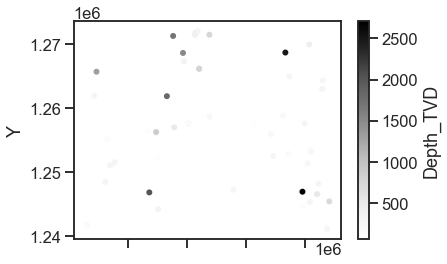

In [17]:
loic_area.plot.scatter('X', 'Y', c='Depth_TVD')

## Load model file

SHEMAT-Suite provides multiple output methods, e.g. VTK or HDF5. Using the Python Wrapper `h5py`, we can easily load and work with HDF5 files. 

In [18]:
parent = 'H:PCT_SHEMAT/2021-08-10_MC_compaction/SHEMAT_MC_realistic_compaction/'

In [20]:
model_path = 'H:PCT_SHEMAT/Advection/GeoMol_jordan_boreholes_fault_horizon_SHSuite_topo_fine_final.h5'
#model_path = parent+'base_model_final.h5'

In [21]:
model = h5py.File(model_path, 'r+')

In [22]:
# Get the model dimensions in x, y, z
x = model['x'][0,0,:]
y = model['y'][0,:,0]
z = model['z'][:,0,0]

These are the parameters, which are written by SHEMAT-Suite:

In [23]:
model['comp']

<HDF5 dataset "comp": shape (100, 100, 100), type "<f8">

In [24]:
list(model.keys())

['comp',
 'delx',
 'dely',
 'delz',
 'df',
 'ec',
 'head',
 'head_bcd',
 'ihead_bcd',
 'itemp_bcd',
 'itemp_bcn',
 'kx',
 'ky',
 'kz',
 'lc',
 'lx',
 'ly',
 'lz',
 'por',
 'pres',
 'q',
 'rc',
 'rhof',
 'temp',
 'temp_bcd',
 'temp_bcn',
 'uindex',
 'visf',
 'vx',
 'vy',
 'vz',
 'x',
 'y',
 'z']

In [25]:
def calc_hf3(data: h5py.File, direction: str='full'):
    dz = data['delz'][:,0,0]
    dy = data['dely'][0,:,0]
    dx = data['delx'][0,0,:]
    temp_diff = np.gradient(data['temp'][:,:,:])
    tdx = temp_diff[2]/dx
    tdy = temp_diff[1]/dy
    tdz = temp_diff[0]/dz
    
    qx = -data['lx'][:,:,:] * tdx
    qy = -data['ly'][:,:,:] * tdy
    qz = -data['lz'][:,:,:] * tdz
    
    if direction=='full':
        return qx, qy, qz
    elif direction=='x':
        return qx
    elif direction=='y':
        return qy
    elif direction=='z':
        return qz

$$ tcf = \frac{(delx_{i+1} * temp_{i+1,j,k} * rhof_{i+1,j,k} * cpf_{i+1,j,k} + delx_i * temp_{i,j,k} * rhof_{i,j,k} * cpf_{i,j,k})}{(delx_{i+1})} $$

$$ qvx = delz_k * dely_j * tcf * vx_{i,j,k} $$

In [47]:
model['delx'][0,0,:]

array([450., 450., 450., 450., 450., 450., 450., 450., 450., 450., 450.,
       450., 450., 450., 450., 450., 450., 450., 450., 450., 450., 450.,
       450., 450., 450., 450., 450., 450., 450., 450., 450., 450., 450.,
       450., 450., 450., 450., 450., 450., 450., 450., 450., 450., 450.,
       450., 450., 450., 450., 450., 450., 450., 450., 450., 450., 450.,
       450., 450., 450., 450., 450., 450., 450., 450., 450., 450., 450.,
       450., 450., 450., 450., 450., 450., 450., 450., 450., 450., 450.,
       450., 450., 450., 450., 450., 450., 450., 450., 450., 450., 450.,
       450., 450., 450., 450., 450., 450., 450., 450., 450., 450., 450.,
       450.])

In [26]:
def adv_hf_x(data: h5py.File, direction: str='full'):
    
    cpf = heatcapacity(data)
    
    dz = data['delz'][:,0,0]
    dy = data['dely'][0,:,0]
    dx = data['delx'][0,0,:]
    
    im = len(dx)
    jm = len(dy)
    km = len(dz)
    qvx_s = np.zeros((100,100))
    qvy_s = np.zeros((100,100))
    qvz_s = np.zeros((100,100))
    
    for i in range(im-1):
                
        ti_one = (dx[i+1] * data['temp'][:,:,i+1] * data['rhof'][:,:,i+1] * cpf[:,:,i+1])
        ti = (dx * data['temp'][:,:,i] * data['rhof'][:,:,i] * cpf[:,:,i])
        tcf = (ti + ti_one) / (dx[i+1] + dx[i])
        qvx = dz[0] * dy[0] * tcf * data['vx'][:,:,i]
        qvx_s = np.dstack((qvx_s, qvx))
        
    for j in range(jm-1):            
        tj_one = (dy[j+1] * data['temp'][:,j+1,:] * data['rhof'][:,j+1,:] * cpf[:,j+1,:])
        tj = (dx * data['temp'][:,j,:] * data['rhof'][:,j,:] * cpf[:,j,:])
        tcf_y = (tj + tj_one) / (dy[j+1] + dy[j])
        qvy = dx[0] * dy[0] * tcf * data['vy'][:,j,:]
        qvy_s = np.dstack((qvy_s, qvy))
        
    for k in range(km-1):
        tk_one = (dz[i+1] * data['temp'][k+1,:,:] * data['rhof'][k+1,:,:] * cpf[k+1,:,:])
        tk = (dz * data['temp'][k,:,:] * data['rhof'][k,:,:] * cpf[k,:,:])
        tcf_z = (tk + tk_one) / (dz[k+1] + dz[k])
        qvz = dx[0] * dy[0] * tcf * data['vz'][:,:,i]
        qvz_s = np.dstack((qvz_s, qvz))
    
    if direction=='full':
        return qvx_s, qvy_s, qvz_s
    
    elif direction=='x':
        return qvx_s
    
    elif direction=='y':
        return qvy_s
    
    elif direction=='z':
        return qvz_s
        

In [31]:
qvx, qvy, qvz = adv_hf_x(model)


In [32]:
np.max(qvz)

0.0906279632409944

!>    @brief calculate advective heat flux at cell faces
!>    @param[in] i grid indices
!>    @param[in] j grid indices
!>    @param[in] k grid indices
!>    @param[in] ismpl local sample index
!>    @return x advective heat flux (W/m^2)
      DOUBLE PRECISION FUNCTION qvx(i,j,k,ismpl)
        use arrays
        use mod_genrl
        IMPLICIT NONE
        integer :: ismpl
        integer :: i, j, k
        DOUBLE PRECISION tcf, vx, rhof, cpf
        EXTERNAL vx, rhof, cpf

        qvx = 0.D0
        IF (i0>1 .AND. i<i0) THEN
          tcf = (delx(i+1)*temp(i+1,j,k,ismpl)*rhof(i+1,j,k,ismpl)* &
            cpf(i+1,j,k,ismpl)+delx(i)*temp(i,j,k,ismpl)*rhof(i,j,k, &
            ismpl)*cpf(i,j,k,ismpl))/(delx(i+1)+delx(i))
          qvx = delz(k)*dely(j)*tcf*vx(i,j,k,ismpl)
        END IF
        RETURN
      END

!>    @brief calculate advective heat flux at cell faces
!>    @param[in] i grid indices
!>    @param[in] j grid indices
!>    @param[in] k grid indices
!>    @param[in] ismpl local sample index
!>    @return y advective heat flux (W/m^2)
      DOUBLE PRECISION FUNCTION qvy(i,j,k,ismpl)
        use arrays
        use mod_genrl
        use mod_temp
        IMPLICIT NONE
        integer :: ismpl
        integer :: i, j, k

        DOUBLE PRECISION tcf, vy, rhof, cpf
        EXTERNAL vy, rhof, cpf

        qvy = 0.D0
        IF (j0>1 .AND. j<j0) THEN
          tcf = (dely(j+1)*temp(i,j+1,k,ismpl)*rhof(i,j+1,k,ismpl)* &
            cpf(i,j+1,k,ismpl)+dely(j)*temp(i,j,k,ismpl)*rhof(i,j,k, &
            ismpl)*cpf(i,j,k,ismpl))/(dely(j+1)+dely(j))
          qvy = delx(i)*delz(k)*tcf*vy(i,j,k,ismpl)
        END IF
        RETURN
      END

!>    @brief calculate advective heat flux at cell faces
!>    @param[in] i grid indices
!>    @param[in] j grid indices
!>    @param[in] k grid indices
!>    @param[in] ismpl local sample index
!>    @return z advective heat flux (W/m^2)
      DOUBLE PRECISION FUNCTION qvz(i,j,k,ismpl)
        use arrays
        use mod_genrl
        use mod_temp
        IMPLICIT NONE
        integer :: ismpl
        integer :: i, j, k

        DOUBLE PRECISION tcf, vz, rhof, cpf
        EXTERNAL vz, rhof, cpf

        qvz = 0.D0
        IF (k0>1 .AND. k<k0) THEN
          tcf = (delz(k+1)*temp(i,j,k+1,ismpl)*rhof(i,j,k+1,ismpl)* &
            cpf(i,j,k+1,ismpl)+delz(k)*temp(i,j,k,ismpl)*rhof(i,j,k, &
            ismpl)*cpf(i,j,k,ismpl))/(delz(k+1)+delz(k))
          qvz = delx(i)*dely(j)*tcf*vz(i,j,k,ismpl)
        END IF
        RETURN
      END


In [39]:
qx, qy, qz = calc_hf3(model)

In [28]:
def add_dataset_to_hdf(f: h5py.File, parameter: str='parameter', values=None):    
    dset = f.create_dataset(parameter, data=values)

Of main importance is usually `'temp'`, `'lz'` and potentially the fluid (darcy) velocities `'vx', 'vy', 'vz'`. Using the function `plot_slice` defined at the beginning of this notebook, we can easily visualize any of these parameters in one of the model's dimension, i.e. x, y, or z.

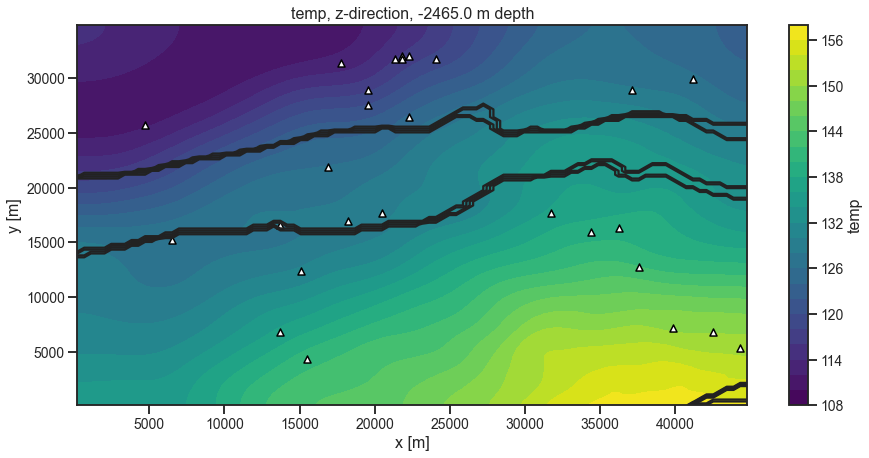

In [61]:
# plot slice
fig = plt.figure(figsize=[15,7])
plot_slice(model_path, parameter='temp', direction='z', cell_number=50)
# plot boreholes
plt.scatter(x[ij_boreholes['i']], y[ij_boreholes['j']], s=50, marker='^', color='white', edgecolor='black');
#plt.savefig('../../figs/Temperature_map_2p5km_depth_fault_horizon.png', dpi=300, bbox_inches='tight')

## INTERIM - BULLARD METHOD DEVELOPMENT

$$ T(z) = T_0 + q \sum^{imax}_{i=1} \frac{\Delta z_i}{\lambda_i} $$

From top to bottom, i layers have the thicknesses of $\Delta z_i$ and the thermal conductivities $\lambda_i$


So basically we calculate the thermal resistances of the layer column.

In [18]:
#def calc_hf2(data: h5py.File, depth_interval:list, model_depth: float=6000., direction: bool=False):
#    """[summary]
#
#    Args:
#        data (h5py.File): [description]
#        depth_interval (list): list of depth interval with [deeper, shallower] values
#        model_depth (float, optional): vertical extent of the model in meter. Defaults to 6000..
#        direction (boolean, optional): if set to True, direction of heatflow will be included, i.e. negative heat flows for outward ones
#
#    Returns:
#        hf [array]: average heat flow over the defined depth interval
#    """
#    zasl = data['z'][:,0,0] - model_depth
#    upper = find_nearest(zasl, depth_interval[0])
#    lower = find_nearest(zasl, depth_interval[1])
#    
#    temp_diff = np.sum(np.gradient(data['temp'][upper:lower+1,:,:], axis=0),axis=0)
#    tc_av = hmean(data['lz'][upper:lower+1,:,:])
#    z_diff = zasl[upper] - zasl[lower]
#
#    if direction==True:
#        hf = - tc_av * (temp_diff/z_diff)
#    else:
#        hf = np.abs(-tc_av * (temp_diff/z_diff))
#
#    return hf
#
#
#def calc_hf2(data, depth_interval:list, model_depth):
#    zasl = data['z'][:,0,0] - model_depth
#    upper = find_nearest(zasl, depth_interval[0])
#    lower = find_nearest(zasl, depth_interval[1])
#    
#    temp_diff = data['temp'][upper,:,:] - data['temp'][lower,:,:]
#    tc_av = hmean(data['lz'][upper:lower+1,:,:])
#    z_diff = zasl[upper] - zasl[lower]
#    
#    return - tc_av * (temp_diff/z_diff)
#
#

## END INTERIM

With the method `calc_hf`, we can calculate the vertical heatflow over a depth interval

In [33]:
nrs = list(exemplary_bholes.values())
bholes = ij_boreholes.query("`Nr.`==@nrs").drop_duplicates(subset='Nr.', keep="last")

In [34]:
bholes

,i,j,Nr.
12,43,82,21
57,10,73,62
95,39,89,77
122,37,62,113
148,49,75,114
156,30,19,122
195,98,15,139
207,82,82,153
243,53,90,167


In [35]:
zasl = model['z'][:,0,0] - 6000.
d_intervall = [-3000, -1500]
upper = find_nearest(zasl, d_intervall[0])
lower = find_nearest(zasl, d_intervall[1])

model['temp'][upper,:,:] - model['temp'][lower,:,:]

array([[58.5631238 , 58.3917666 , 58.14327114, ..., 81.15544685,
        78.31511501, 76.32845853],
       [58.54280712, 58.36990598, 58.08095721, ..., 80.11851198,
        77.07905442, 74.90556363],
       [58.5742684 , 58.40520024, 58.13587577, ..., 78.46039255,
        74.74555316, 72.02226672],
       ...,
       [56.11335722, 56.12622046, 56.14859771, ..., 56.00309834,
        56.10338629, 56.22888757],
       [56.12451922, 56.13656087, 56.15710426, ..., 56.01693835,
        56.11532363, 56.22942735],
       [56.13016913, 56.1418268 , 56.16144342, ..., 56.02680119,
        56.11594182, 56.17838772]])

In [36]:
np.sum(np.gradient(model['temp'][upper:lower+1,:,:], axis=0),axis=0)

array([[-61.2306806 , -61.04873318, -60.7884643 , ..., -84.04469769,
        -81.24498782, -79.27140918],
       [-61.20628786, -61.02332465, -60.71583455, ..., -83.04550232,
        -79.97700529, -77.79907774],
       [-61.23834925, -61.05829756, -60.77147389, ..., -81.34375984,
        -77.58213509, -74.85537139],
       ...,
       [-58.66311773, -58.67665842, -58.70020237, ..., -58.59502527,
        -58.70061843, -58.83498352],
       [-58.67482976, -58.68751421, -58.70912553, ..., -58.61069424,
        -58.71180291, -58.83630482],
       [-58.68075171, -58.69303938, -58.71367616, ..., -58.62191722,
        -58.71282597, -58.77690268]])

In [37]:
def calc_hf2(data: h5py.File, depth_interval:list, model_depth: float=6000., direction: bool=False):
    """[summary]

    Args:
        data (h5py.File): [description]
        depth_interval (list): list of depth interval with [deeper, shallower] values
        model_depth (float, optional): vertical extent of the model in meter. Defaults to 6000..
        direction (boolean, optional): if set to True, direction of heatflow will be included, i.e. negative heat flows for outward ones

    Returns:
        hf [array]: average heat flow over the defined depth interval
    """
    zasl = data['z'][:,0,0] - model_depth
    upper = find_nearest(zasl, depth_interval[0])
    lower = find_nearest(zasl, depth_interval[1])
    
    temp_diff = np.sum(np.gradient(data['temp'][upper:lower+1,:,:], axis=0),axis=0)
    #temp_diff = data['temp'][upper,:,:] - data['temp'][lower,:,:]
    tc_av = hmean(data['lz'][upper:lower+1,:,:])
    z_diff = np.sum(np.gradient(zasl[upper:lower+1], axis=0),axis=0)
    #z_diff = zasl[upper] - zasl[lower]

    if direction==True:
        hf = - tc_av * (temp_diff/z_diff)
    else:
        hf = np.abs(-tc_av * (temp_diff/z_diff))

    return hf

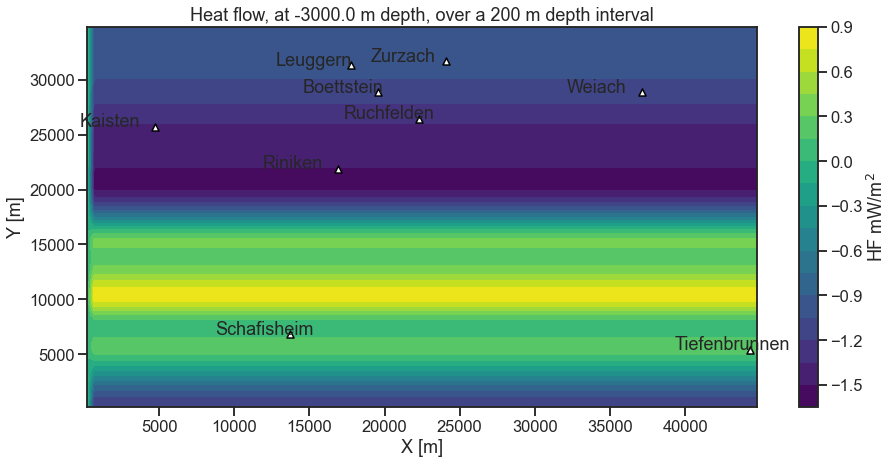

In [47]:
lower, shallower = -3100, -2900
atdepth = lower - (lower-shallower)/2
delz = model['delz'][0,0,0]
zmin = 6000
qs = calc_hf2(model, [lower, shallower], zmin, direction=False)

cell_number = np.abs(((shallower - (np.abs(lower-shallower)/2) + zmin) ) /delz).astype(int)
ui_cs = model['uindex'][cell_number,:,:]

fig = plt.figure(figsize=[15,7])
cs = plt.contourf(x,y,qs*1000, 20, cmap='viridis')
cs = plt.contourf(x,y,qvz[42,:,:]*1000, 20, cmap='viridis')
#plt.contour(x,y,ui_cs, colors='k')
plt.colorbar(cs, label='HF mW/m$^2$')
plt.scatter(x[bholes['i']], y[bholes['j']], s=50, marker='^', color='white', edgecolor='black')
plt.title(f"Heat flow, at {atdepth} m depth, over a {np.abs(lower-shallower)} m depth interval")
for ID in exemplary_bholes:
    plt.text(x[bholes.loc[bholes['Nr.']==exemplary_bholes[ID]]['i']]-5000, 
             y[bholes.loc[bholes['Nr.']==exemplary_bholes[ID]]['j']], f'{ID}')
               
plt.xlabel('X [m]')
plt.ylabel('Y [m]');
#fig.savefig(f'../../figs/HF_COND_{int(atdepth)}m_depth_fault_horizon.png', dpi=300, bbox_inches='tight');

## Ensemble calculation

In [33]:
deeper, shallower = -2350, -1650
atdepth = deeper - (deeper-shallower)/2
delz = model['delz'][0,0,0]
zmin = 6000
zasl = model['z'][:,0,0]-zmin

In [34]:
model_path = glob.glob(parent+'PCT*.h5')

In [35]:
dat0 = read_hdf_file(model_path[0])
q_array = calc_hf2(dat0, [deeper, shallower], zmin, direction=False)
idx_v = find_nearest(zasl, (deeper-shallower)/2 + shallower)
v_array = dat0['vz'][idx_v,:,:]
for fid in model_path[1:]:
    dat = read_hdf_file(fid)
    cq = calc_hf2(dat, [deeper, shallower], zmin, direction=False)
    cv = dat['vz'][idx_v,:,:]
    q_array = np.dstack((q_array,cq))
    v_array = np.dstack((v_array,cv))

In [36]:
mean_q = np.mean(q_array, axis=2)
stdv_q = np.std(q_array, axis=2)
median_q = np.median(q_array, axis=2)

In [37]:
stdv_v = np.std(v_array, axis=2)

In [38]:
qs = [mean_q, stdv_q, median_q, stdv_v]
qs_s = ['mean HF', 'standard deviation HF', 'median HF', 'stdev vertical velocity']

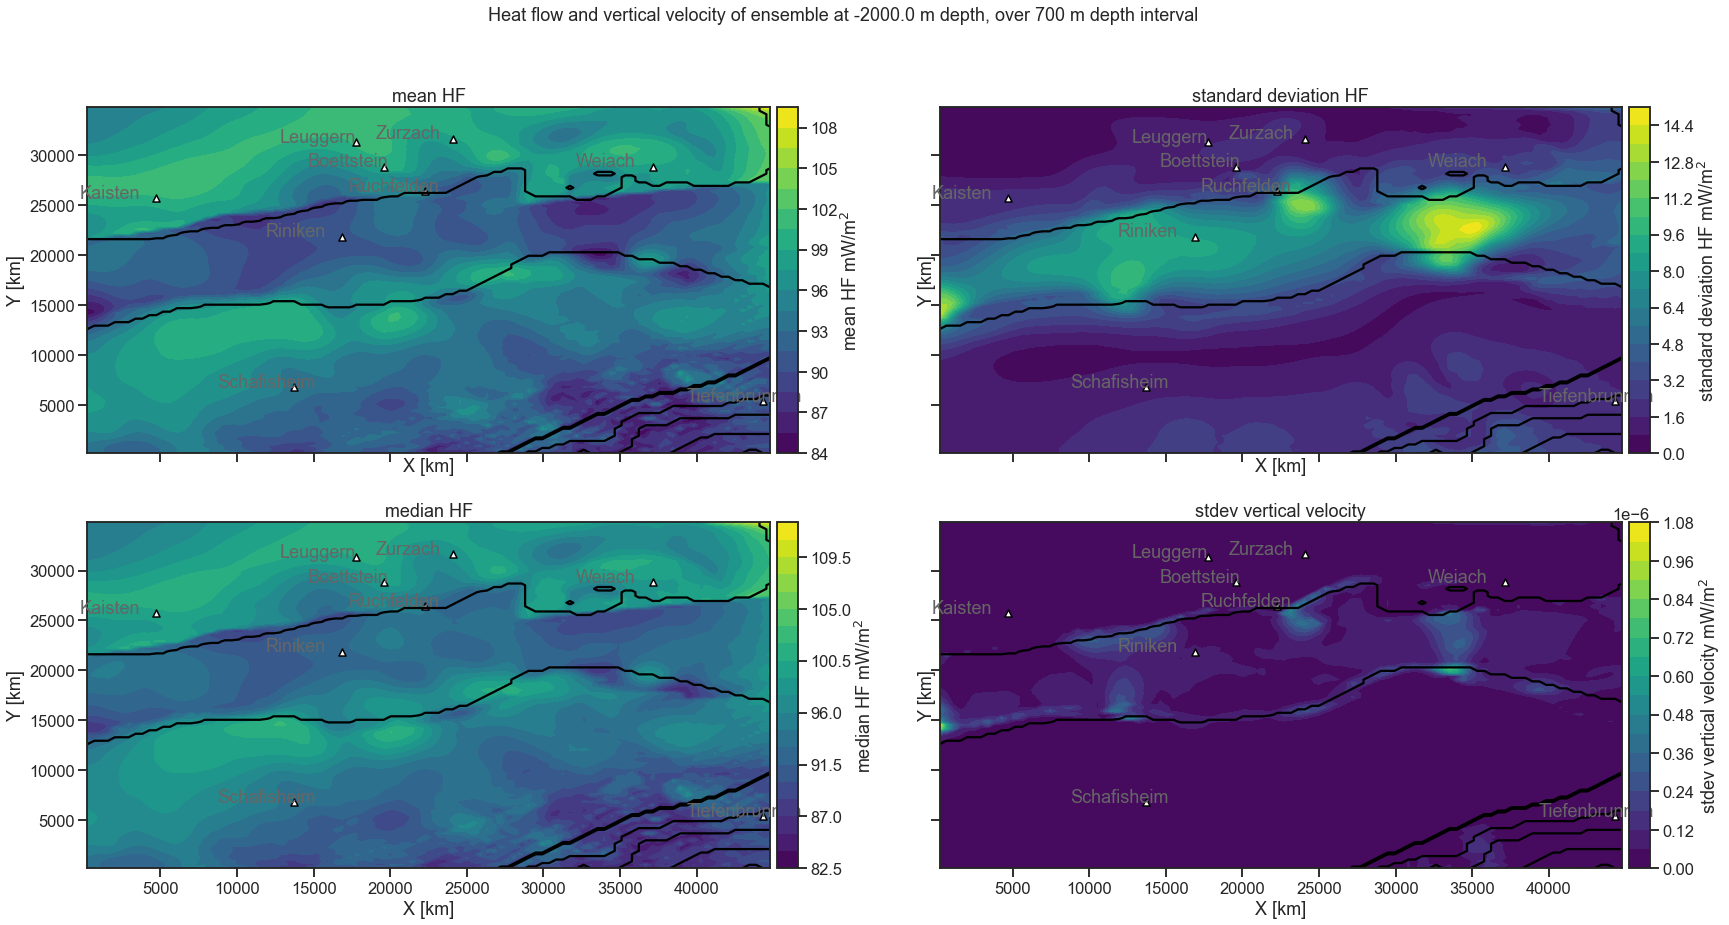

In [45]:
fig, axs = plt.subplots(2,2, sharex=True, sharey=True, figsize=[28,14])
cell_number = np.abs(((shallower - (np.abs(deeper-shallower)/2) + zmin) ) /delz).astype(int)
ui_cs = model['uindex'][cell_number,:,:]
axs = axs.ravel()
for i in range(4):
    divider = make_axes_locatable(axs[i])
    cax = divider.append_axes('right', size='3%', pad=0.1)
    cs = axs[i].contourf(x,y,qs[i]*1000, 20, cmap='viridis')
    axs[i].contour(x,y,ui_cs, colors='k')
    fig.colorbar(cs, cax=cax, orientation='vertical', label=f'{qs_s[i]} mW/m$^2$')
    axs[i].scatter(x[bholes['i']], y[bholes['j']], s=50, marker='^', color='white', edgecolor='black')
    axs[i].set_title(qs_s[i])
    axs[i].set_xlabel('X [km]')
    axs[i].set_ylabel('Y [km]')
    for ID in exemplary_bholes:
        axs[i].text(x[bholes.loc[bholes['Nr.']==exemplary_bholes[ID]]['i']]-5000, 
                 y[bholes.loc[bholes['Nr.']==exemplary_bholes[ID]]['j']], f'{ID}', color=(.4,.4,.4))
#fig.colorbar(cs, cax=axs[3], label=f'{qs_s[i]} m/s')
#fig.tight_layout()
fig.suptitle(f'Heat flow and vertical velocity of ensemble at {deeper - (deeper-shallower)/2} m depth, over {np.abs(deeper-shallower)} m depth interval', fontsize=18);
fig.savefig(f'../../figs/heat_flow_mean_stdev_90mW_vz{deeper - (deeper-shallower)/2}mdepth.png', dpi=300, bbox_inches='tight')

In [86]:
exemplary_bholes

{'Boettstein': 21,
 'Kaisten': 62,
 'Leuggern': 77,
 'Riniken': 113,
 'Ruchfelden': 114,
 'Schafisheim': 122,
 'Tiefenbrunnen': 139,
 'Weiach': 153,
 'Zurzach': 167}

In [87]:
all_temps = {'Boettstein': np.zeros(100),
 'Kaisten': np.zeros(100),
 'Leuggern': np.zeros(100),
 'Riniken': np.zeros(100),
 'Ruchfelden': np.zeros(100),
 'Schafisheim': np.zeros(100),
 'Tiefenbrunnen': np.zeros(100),
 'Weiach': np.zeros(100),
 'Zurzach': np.zeros(100)}
all_uix = {'Boettstein': np.zeros(100),
 'Kaisten': np.zeros(100),
 'Leuggern': np.zeros(100),
 'Riniken': np.zeros(100),
 'Ruchfelden': np.zeros(100),
 'Schafisheim': np.zeros(100),
 'Tiefenbrunnen': np.zeros(100),
 'Weiach': np.zeros(100),
 'Zurzach': np.zeros(100)}
for fid in model_path:
    mod_file = read_hdf_file(fid)
    
    for i,j in enumerate(exemplary_bholes):
        nr = exemplary_bholes[j]
        bhole = measured.query(f"`Nr.`=={nr} and (Methode=='HRT' or Methode=='HT')")
        i_sim = bhole['i'].unique()[0] - 1
        j_sim = bhole['j'].unique()[0] - 1
        
        bhole_temp = mod_file['temp'][:,j_sim,i_sim]
        bhole_uix = mod_file['uindex'][:,j_sim,i_sim]
        
        st_temp = np.column_stack([all_temps[j],bhole_temp])
        st_uix = np.column_stack([all_uix[j],bhole_uix])
        
        all_temps[j] = st_temp
        all_uix[j] = st_uix
        
for l,m in enumerate(exemplary_bholes):
    all_temps[m] = all_temps[m][:,1:]
    all_uix[m] = all_uix[m][:,1:]

In [88]:
all_temps['Riniken']

array([[232.36160258, 233.95975333, 233.90154194, ..., 166.99421227,
        234.59717756, 230.64863869],
       [229.58392068, 231.17614503, 231.10294724, ..., 164.39421089,
        231.79433301, 227.87775743],
       [226.83057055, 228.41150311, 228.31736904, ..., 161.75408354,
        229.00210891, 225.14574866],
       ...,
       [  9.11831367,   9.11750496,   9.11734535, ...,   9.06548009,
          9.11748889,   9.11954581],
       [  9.05911848,   9.05871497,   9.05863224, ...,   9.03274473,
          9.05870298,   9.05973833],
       [  9.        ,   9.        ,   9.        , ...,   9.        ,
          9.        ,   9.        ]])

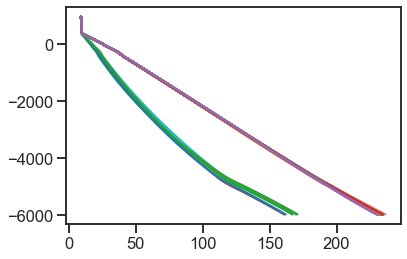

In [89]:
plt.plot(all_temps['Riniken'], z-6000);

In [90]:
z[64]-6000

-1485.0

In [91]:
all_uix['Weiach'][:,::8]

array([[17., 17., 17., ..., 17., 17., 17.],
       [17., 17., 17., ..., 17., 17., 17.],
       [17., 17., 17., ..., 17., 17., 17.],
       ...,
       [18., 18., 18., ..., 18., 18., 18.],
       [18., 18., 18., ..., 18., 18., 18.],
       [18., 18., 18., ..., 18., 18., 18.]])

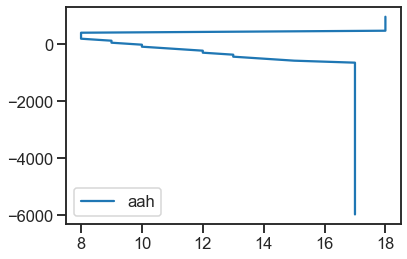

In [92]:
plt.plot(all_uix['Weiach'][:,26], z-6000, label='aah')
plt.legend();

## End Ensemble Calculation

## Comparison Measured to Simulated Temperatures

In [25]:
# Example Riniken
riniken = measured.query("`Nr.`==113 and Run==6")

In [26]:
riniken_sim = model['temp'][:,61,36]
riniken_uix = model['uindex'][:,61,36]

In [27]:
litho_changes = np.where(riniken_uix[:-1] != riniken_uix[1:])[0]
zasl = z - 6000

litho_f_color = list(riniken_uix[litho_changes])
litho_f_color.append(riniken_uix[-1])

In [28]:
riniken.head()

,Temperatur[C],Tiefe[m.u.T.],Nr.,Run,Datum,Methode,Measurement_ID,x,y,z,Z[asl],i,j,k,var_flag,flag,error,Name
124,13.54,62.48,113,6,1984-11-24,HRT,5964,2.656605e+06,1.261799e+06,385.0,322.52,37,62,90,2,1,0.7,!Riniken_HRT
125,16.31,120.58,113,6,1984-11-24,HRT,5969,2.656605e+06,1.261799e+06,385.0,264.42,37,62,89,2,1,0.7,!Riniken_HRT
126,19.62,187.09,113,6,1984-11-24,HRT,5975,2.656605e+06,1.261799e+06,385.0,197.91,37,62,89,2,1,0.7,!Riniken_HRT
127,22.84,255.13,113,6,1984-11-24,HRT,5980,2.656605e+06,1.261799e+06,385.0,129.87,37,62,88,2,1,0.7,!Riniken_HRT
128,26.99,331.58,113,6,1984-11-24,HRT,5986,2.656605e+06,1.261799e+06,385.0,53.42,37,62,86,2,1,0.7,!Riniken_HRT


NameError: name 'all_temps' is not defined

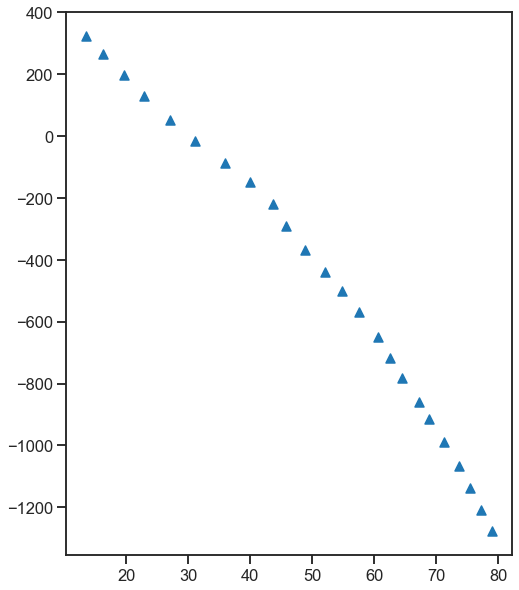

In [29]:
fig = plt.figure(figsize=[8,10])
plt.scatter(riniken["Temperatur[C]"], riniken["Z[asl]"], marker='^', label='measured')
plt.plot(all_temps['Riniken'], z-6000, '-')
#plt.hlines(zasl[litho_changes],0,85, color='black')
apa=0.7

for i in range(len(zasl[litho_changes])):
    try:
        plt.axhspan(zasl[litho_changes][i+1], 
                   zasl[litho_changes][i], 
                    facecolor=col_dict[litho_f_color[i+1]], alpha=apa, zorder=-1)
    except IndexError:
        plt.axhspan(zasl[0], zasl[litho_changes][0],
                   facecolor=col_dict[litho_f_color[0]], alpha=apa, zorder=-1)
        plt.axhspan(zasl[-1], zasl[litho_changes][i],
                   facecolor=col_dict[litho_f_color[-1]], alpha=apa, zorder=-1)
        
plt.legend()
plt.ylim(-6500, 500)
plt.xlim(0, 100)
plt.ylabel('Depth [m.a.s.l.]')
plt.xlabel('Temperature [°C]')
plt.title('Riniken')

In [30]:
measured_new = measured.drop(measured[(measured['Nr.'] == 113) & (measured['Run'] < 5)].index)
#measured_new = pd.read_csv('../../data/processed/temperature_data/borehole_temperatures_w_ijk.csv')

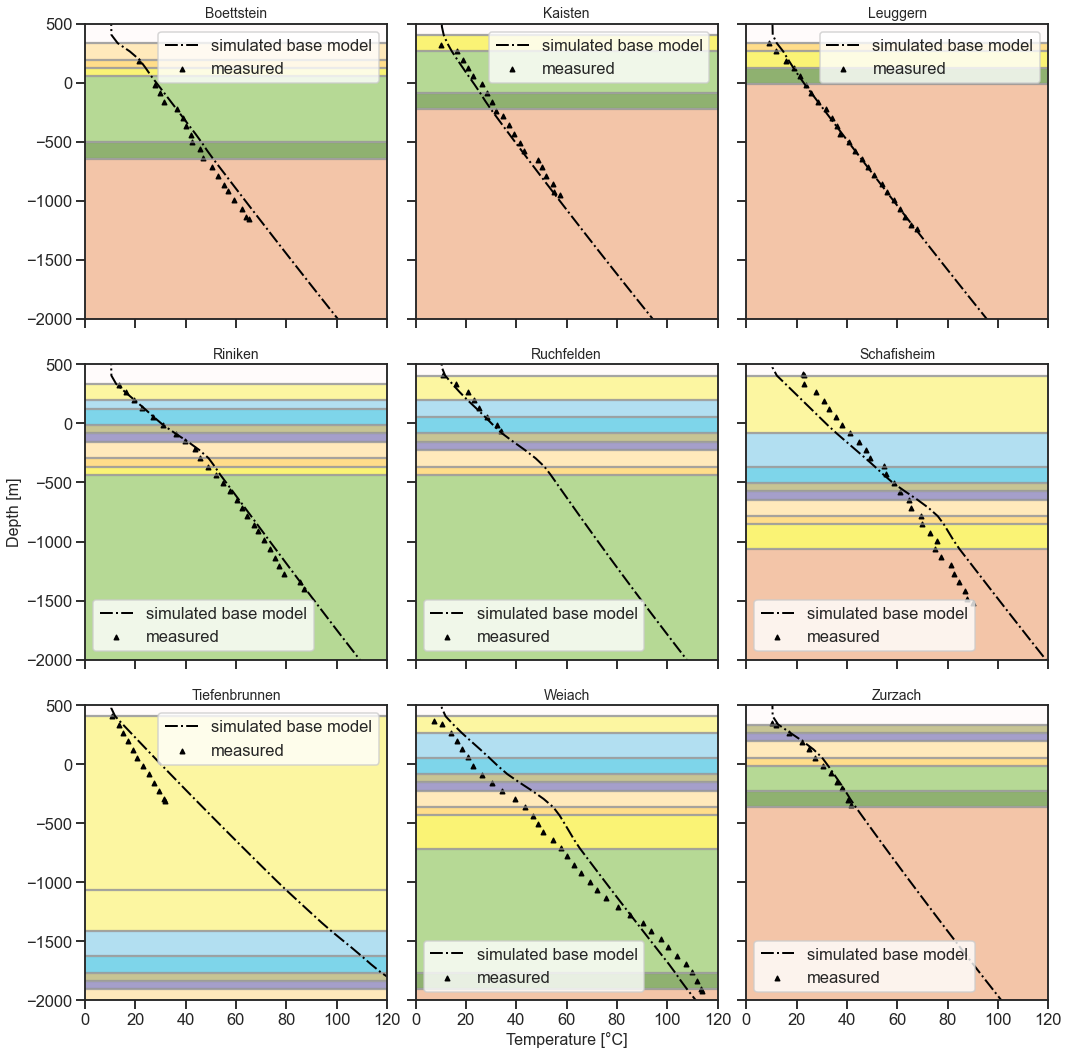

In [32]:
fig, axs = plt.subplots(3,3, figsize=(15, 15), facecolor='w', edgecolor='k', sharex=True, sharey=True)
#fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
zasl = z - 6000
reduction = 1
apa=0.7

for i,j in enumerate(exemplary_bholes):
    
    nr = exemplary_bholes[j]
    bhole = measured_new.query(f"`Nr.`=={nr} and (Methode=='HRT' or Methode=='HT')")
    i_sim = bhole['i'].unique()[0] - 1
    j_sim = bhole['j'].unique()[0] - 1
    bhole_sim = model['temp'][:,j_sim,i_sim]
    bhole_uix = model['uindex'][:,j_sim,i_sim]
    litho_changes = np.where(bhole_uix[:-1] != bhole_uix[1:])[0]
    litho_f_color = list(bhole_uix[litho_changes])
    litho_f_color.append(bhole_uix[-1])
    
    axs[i].scatter(bhole["Temperatur[C]"][::reduction], bhole["Z[asl]"][::reduction],
                   s=20, marker='^', c='black', label='measured', zorder=1) #, c=bhole["Run"][::reduction], cmap='RdGy'
    
    axs[i].plot(bhole_sim, zasl, 'k-.', linewidth=2, label='simulated base model')
    #axs[i].plot(all_temps[j], zasl, '-.', c='grey', linewidth=2, alpha=.6, zorder=0)
    
          
    axs[i].hlines(zasl[litho_changes],0,150, color='grey', alpha=0.7)
    axs[i].legend()
    
    axs[i].set_ylim(-2000, 500)
    axs[i].set_xlim(0, 120)
    axs[i].set_title(j, fontsize=14)
    for l in range(len(zasl[litho_changes])):
        try:
            axs[i].axhspan(zasl[litho_changes][l+1], 
                       zasl[litho_changes][l], 
                        facecolor=col_dict[litho_f_color[l+1]], alpha=apa, zorder=-1)
        except IndexError:
            axs[i].axhspan(zasl[0], zasl[litho_changes][0],
                       facecolor=col_dict[litho_f_color[0]], alpha=apa, zorder=-1)
            axs[i].axhspan(zasl[-1], zasl[litho_changes][l],
                       facecolor=col_dict[litho_f_color[-1]], alpha=apa, zorder=-1)
            
axs[3].set_ylabel('Depth [m]', fontsize=16)
axs[7].set_xlabel('Temperature [°C]', fontsize=16)
fig.tight_layout()

#fig.savefig('../../figs/Temperature_sim_meas_HRT_HT_comparison_MC_spatialHF_compaction.png', dpi=300, bbox_inches='tight')

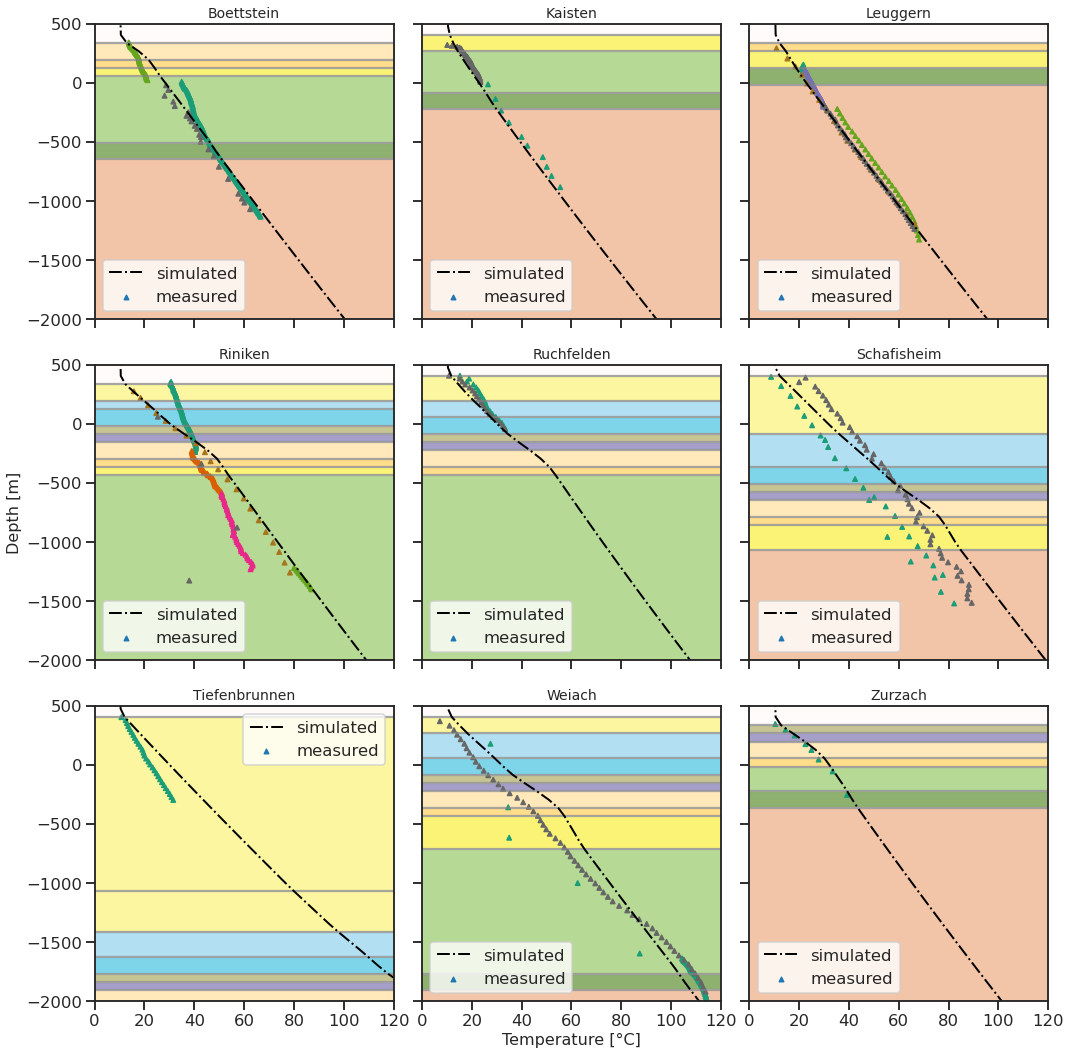

In [225]:
fig, axs = plt.subplots(3,3, figsize=(15, 15), facecolor='w', edgecolor='k', sharex=True, sharey=True)
#fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
zasl = z - 6000
reduction = 5

for i,j in enumerate(exemplary_bholes):
    
    nr = exemplary_bholes[j]
    bhole = measured.query(f"`Nr.`=={nr} and (Methode=='HRT' or Methode=='HT')")
    i_sim = bhole['i'].unique()[0] - 1
    j_sim = bhole['j'].unique()[0] - 1
    bhole_sim = model['temp'][:,j_sim,i_sim]
    bhole_uix = model['uindex'][:,j_sim,i_sim]
    litho_changes = np.where(bhole_uix[:-1] != bhole_uix[1:])[0]
    litho_f_color = list(bhole_uix[litho_changes])
    litho_f_color.append(bhole_uix[-1])
    
    axs[i].scatter(bhole["Temperatur[C]"][::reduction], bhole["Z[asl]"][::reduction],
                   s=20, marker='^', c=bhole["Run"][::reduction], label='measured', cmap='Dark2')
    
    axs[i].plot(bhole_sim, zasl, 'k-.', linewidth=2, label='simulated')
          
    axs[i].hlines(zasl[litho_changes],0,150, color='grey', alpha=0.7)
    axs[i].legend()
    
    axs[i].set_ylim(-2000, 500)
    axs[i].set_xlim(0, 120)
    axs[i].set_title(j, fontsize=14)
    for l in range(len(zasl[litho_changes])):
        try:
            axs[i].axhspan(zasl[litho_changes][l+1], 
                       zasl[litho_changes][l], 
                        facecolor=col_dict[litho_f_color[l+1]], alpha=apa, zorder=-1)
        except IndexError:
            axs[i].axhspan(zasl[0], zasl[litho_changes][0],
                       facecolor=col_dict[litho_f_color[0]], alpha=apa, zorder=-1)
            axs[i].axhspan(zasl[-1], zasl[litho_changes][l],
                       facecolor=col_dict[litho_f_color[-1]], alpha=apa, zorder=-1)
            
axs[3].set_ylabel('Depth [m]', fontsize=16)
axs[7].set_xlabel('Temperature [°C]', fontsize=16)
fig.tight_layout()

#fig.savefig('../../figs/Temperature_sim_meas_HRT_comparison.png', dpi=300, bbox_inches='tight')

The coloring by uindex, at least by comparing with the 1D inversions, shows strong deviations for some boreholes. So create a geological model with borehole data included!

In [143]:
diff_name = 'D:PCT_SHEMAT/Conduction/FW_results.dat'

In [148]:
#diffs = np.loadtxt('../../models/20201020_GeoMol_jordan_erode_SHEMAT-Suite_export/GeoMol_jordan_erode_SHSuite_topo_fine_var_bcn_7km_UPDATED.txt_final.dat',skiprows=3,usecols=(8,),dtype=float)
#diffs = np.loadtxt('../../../../polybox/SHEMAT_GeoMol/GeoMol_jordan_erode_SHSuite_topo_fine_AD_final.dat',skiprows=3,usecols=(8,),dtype=float)
diffs = np.loadtxt('../../models/20201020_GeoMol_jordan_erode_SHEMAT-Suite_export/FW_results.dat',skiprows=3,dtype=float)

In [144]:
sim_obs = load_inv(diff_name)

In [145]:
sim_obs.query("i==80")

,i,j,k,unit,type,calc,obs,err,diff,res,time,ozone
41,80,46,92,7,2,12.033621,7.7,0.7,4.333621,6.190888,60000000.0,1
42,80,46,91,7,2,15.160678,10.1,0.7,5.060678,7.229540,60000000.0,1
43,80,46,90,7,2,18.301251,15.0,0.7,3.301251,4.716073,60000000.0,1
44,80,46,89,7,2,21.454581,16.2,0.7,5.254581,7.506545,60000000.0,1


In [152]:
shmdat = pd.read_csv('../../data/processed/temperature_data/2021-05-11_temp_for_shemat_HRT_HT_BHT.csv', sep='\t')
rindat_read = shmdat.query('Name=="!Riniken_HRT"')

<AxesSubplot:xlabel='Temperatur[C]', ylabel='k'>

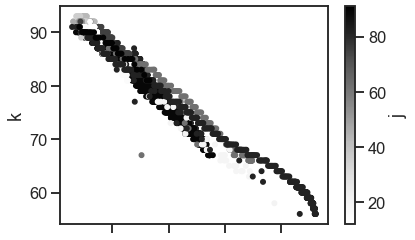

In [155]:
shmdat.plot.scatter('Temperatur[C]', 'k', c='j')

In [156]:
shmdat_cl = shmdat.drop_duplicates()

In [164]:
rindat_read.drop_duplicates()

,Temperatur[C],error,i,j,k,var_flag,flag,Name
2969,79.81,0.7,37,62,68,2,1,!Riniken_HRT
2970,79.94,0.7,37,62,68,2,1,!Riniken_HRT
2971,80.06,0.7,37,62,68,2,1,!Riniken_HRT
2972,80.19,0.7,37,62,68,2,1,!Riniken_HRT
2973,80.31,0.7,37,62,68,2,1,!Riniken_HRT
...,...,...,...,...,...,...,...,...
3152,58.30,0.7,37,62,72,2,1,!Riniken_HRT
3153,58.90,0.7,37,62,72,2,1,!Riniken_HRT
3154,57.30,0.7,37,62,71,2,1,!Riniken_HRT
3155,62.70,0.7,37,62,69,2,1,!Riniken_HRT


<AxesSubplot:xlabel='Temperatur[C]', ylabel='k'>

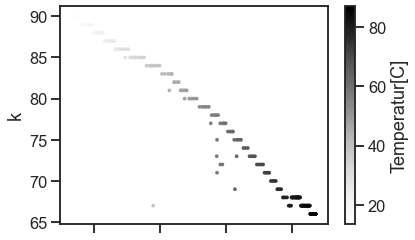

In [165]:
rindat_read.plot.scatter('Temperatur[C]', 'k', c='Temperatur[C]', marker='.')

<AxesSubplot:xlabel='obs', ylabel='k'>

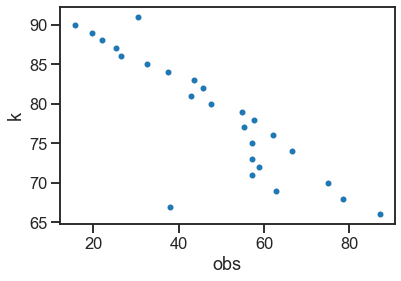

In [149]:
rin_dat = sim_obs.loc[sim_obs['j']==62]
rin_dat.plot.scatter('obs', 'k')

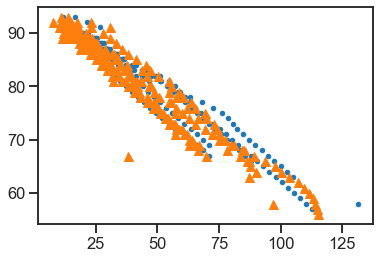

In [147]:
plt.plot(sim_obs['calc'], sim_obs['k'], '.')
plt.plot(sim_obs['obs'], sim_obs['k'], '^')

In [27]:
unique_bholes = sim_obs[['i','j']].drop_duplicates().reset_index(inplace=False)

In [57]:
unique_bholes = pd.read_csv('../../data/processed/temperature_data/unique_boreholes_SHEMAT-Model_w_names.csv')

In [62]:
unique_bholes

,index,i,j,name
0,0,94,19,Aqui
1,1,43,78,Beznau
2,6,45,50,Birmenstorf
3,10,43,82,Boettstein
4,33,14,43,Densbueren
5,36,91,85,Eglisau
6,37,76,45,Furthal 706
7,41,80,46,Furthal 709
8,45,83,36,Gubrist
9,47,40,48,Hausen


/home/bl2/miniconda3/envs/env_datasci/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


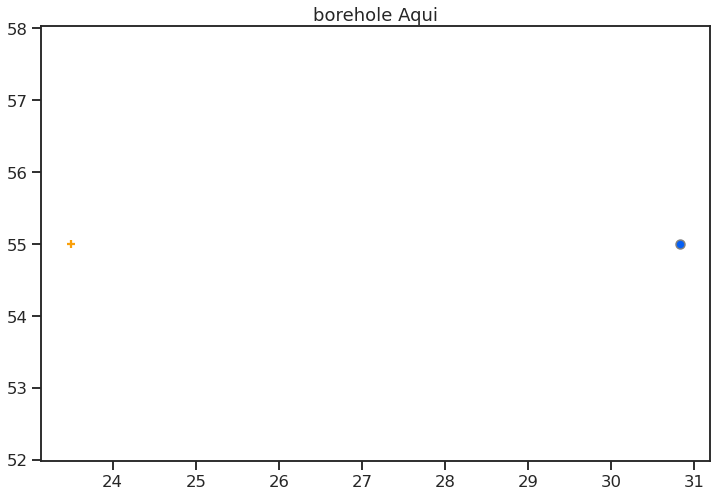

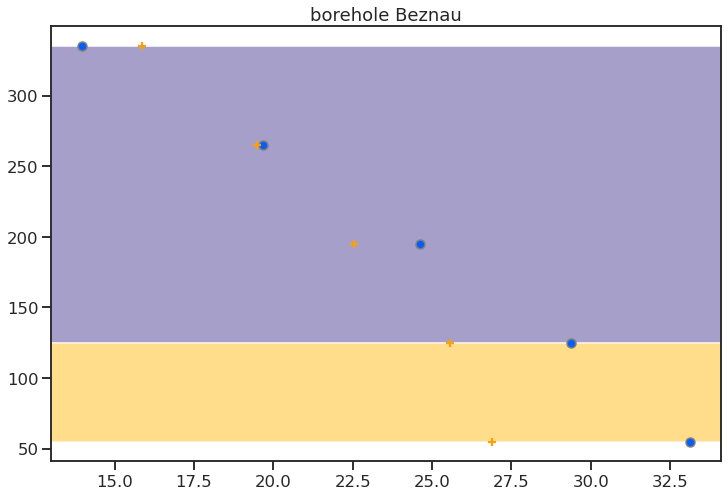

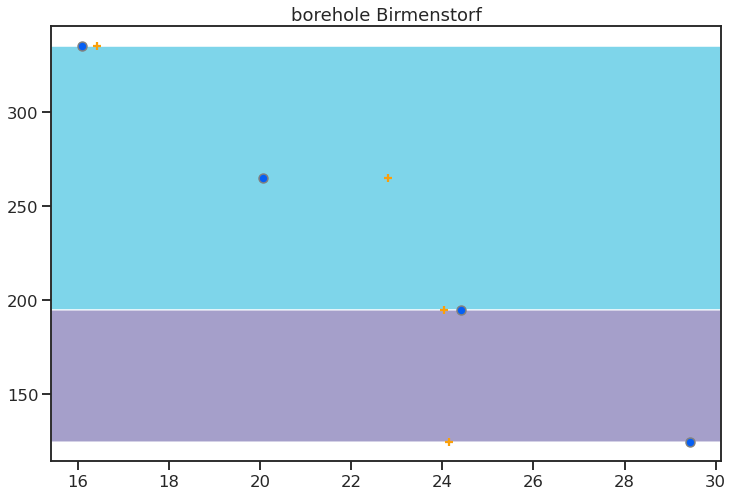

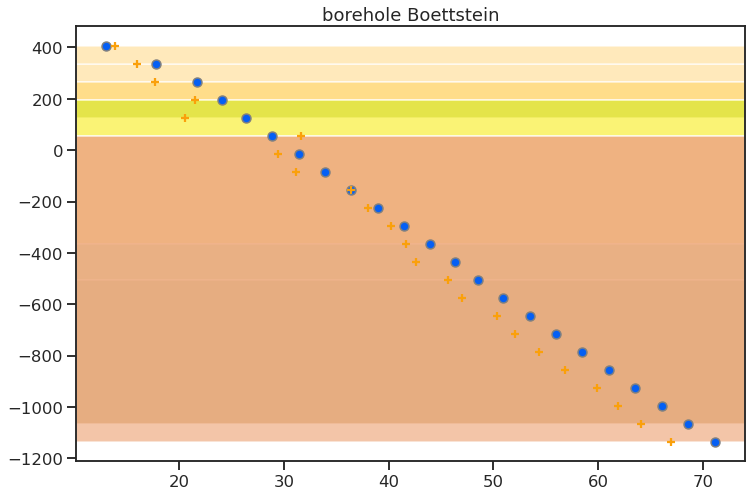

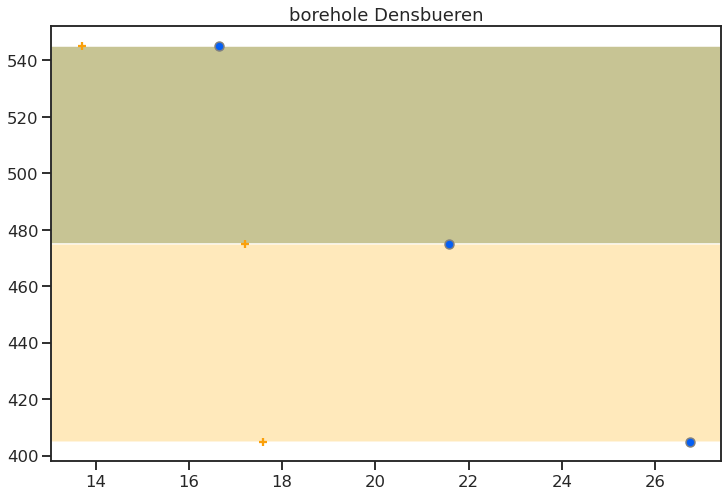

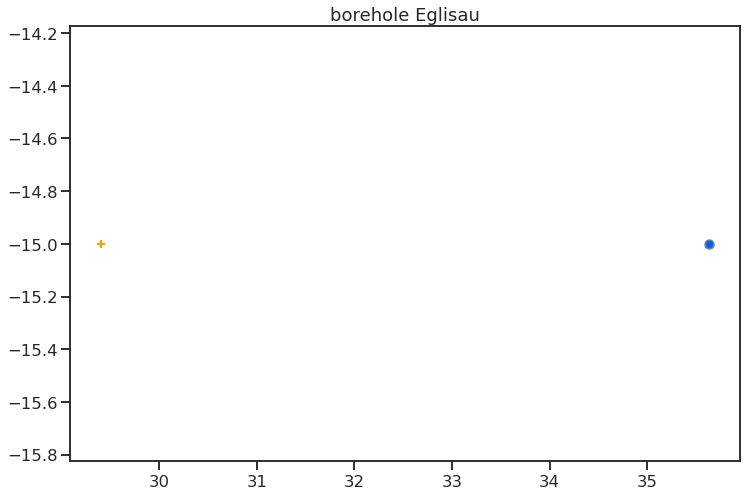

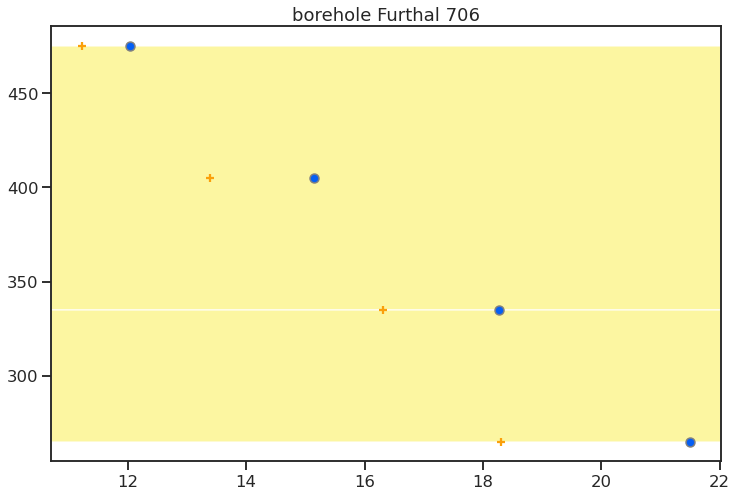

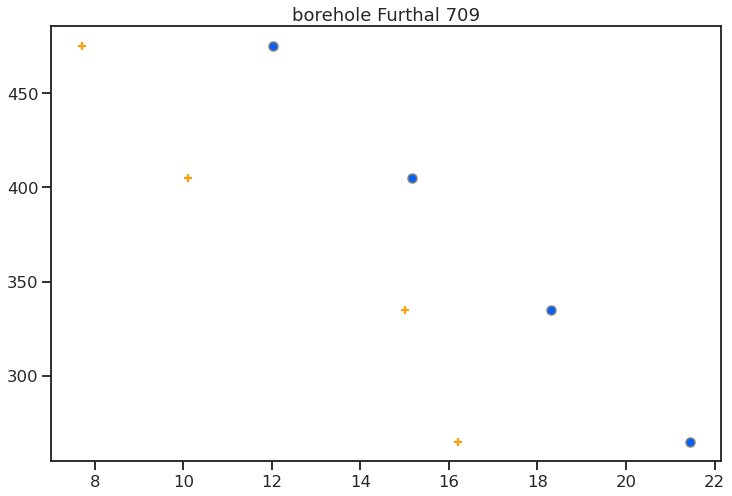

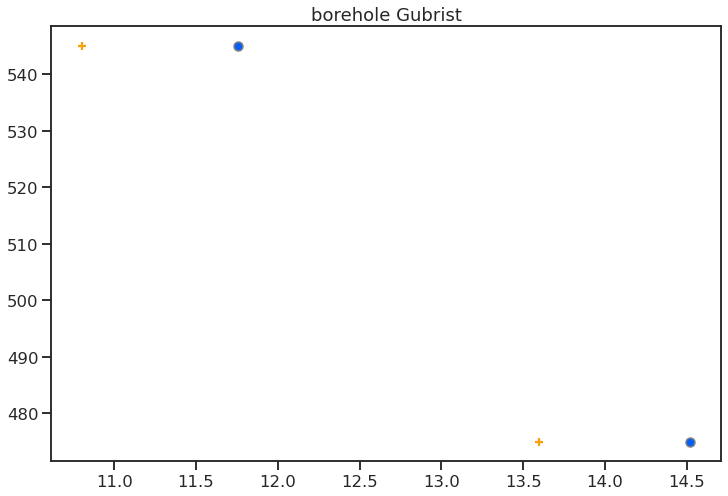

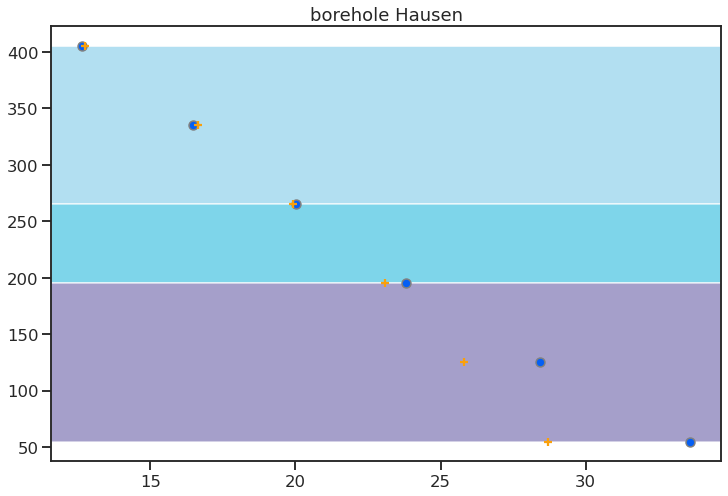

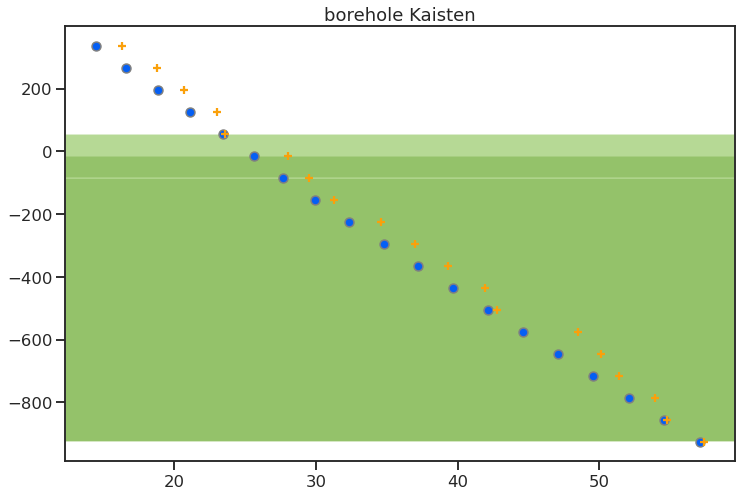

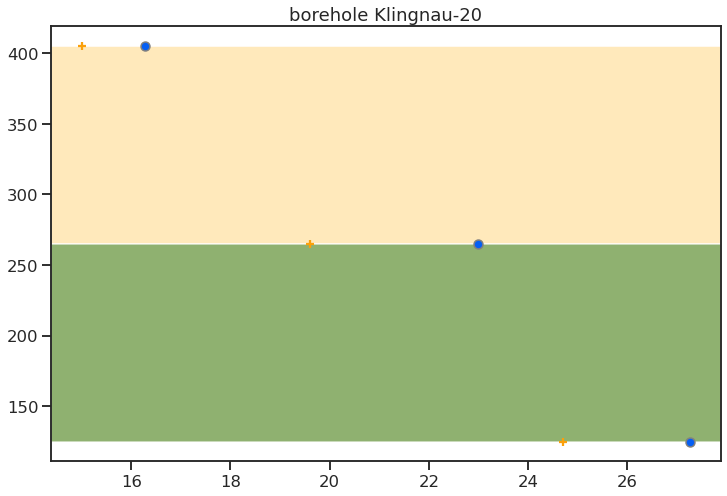

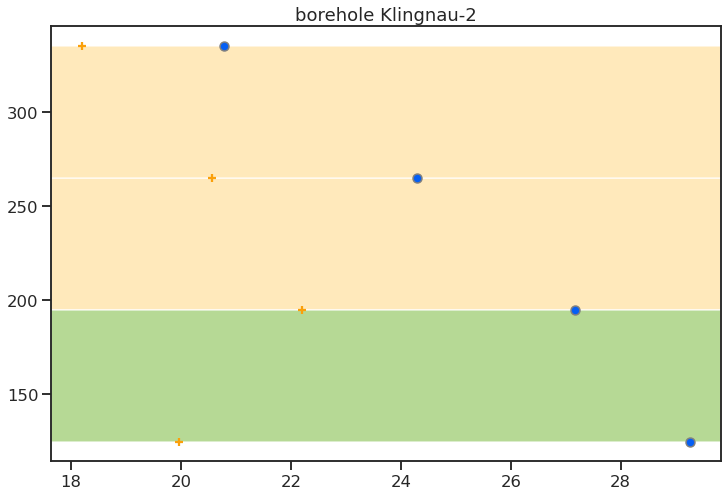

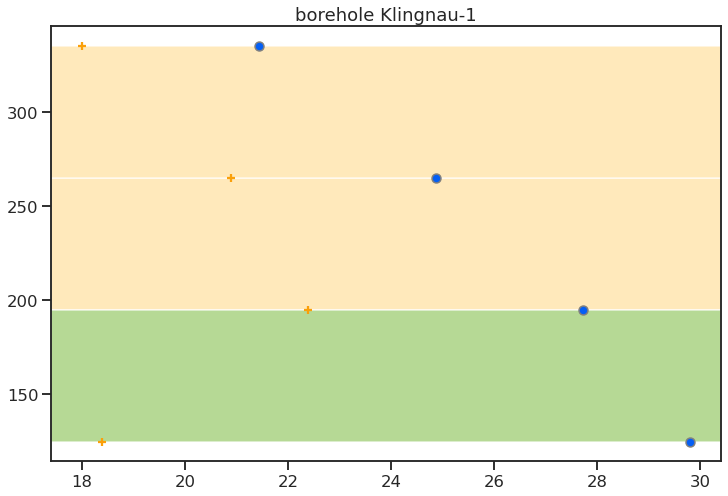

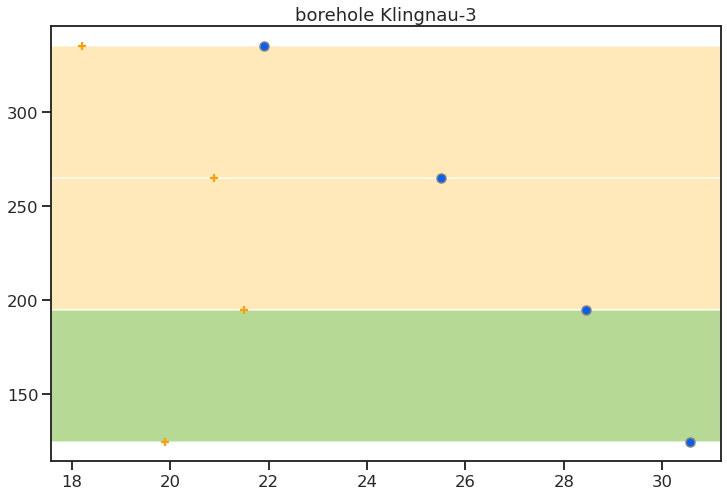

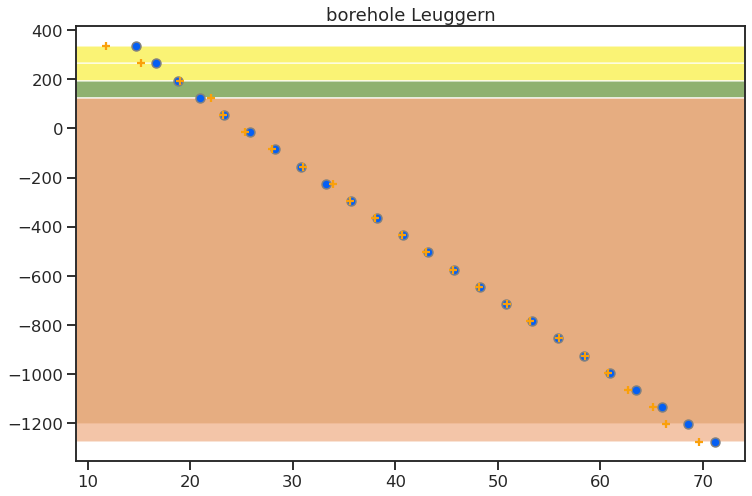

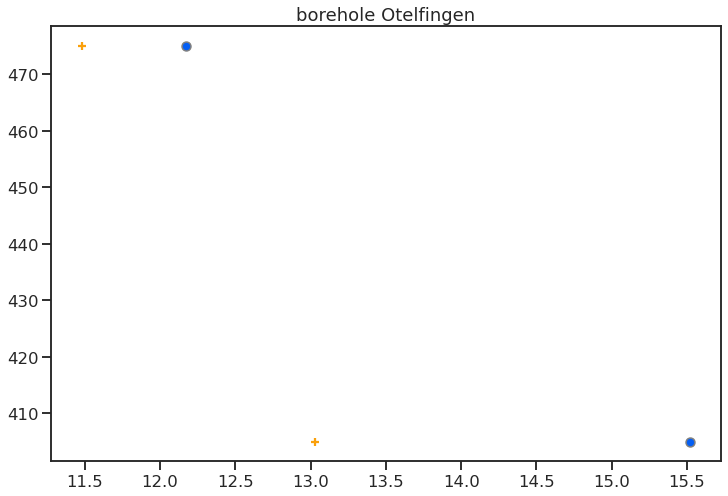

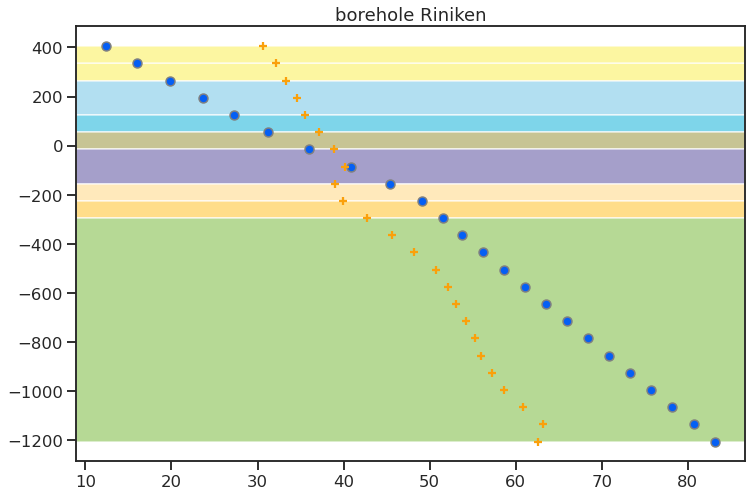

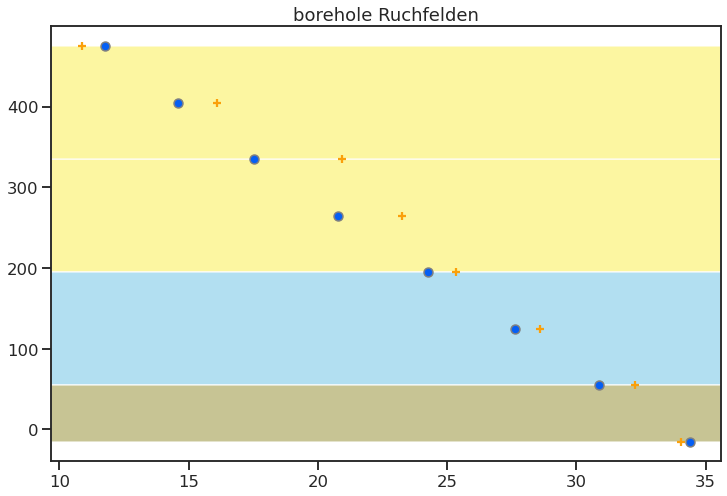

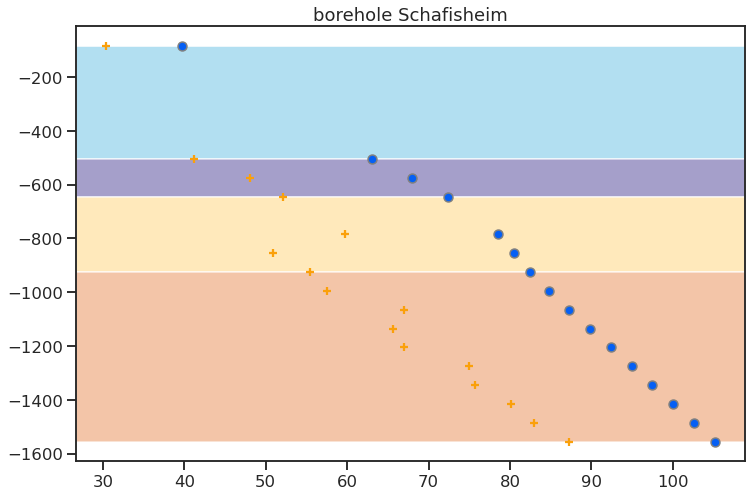

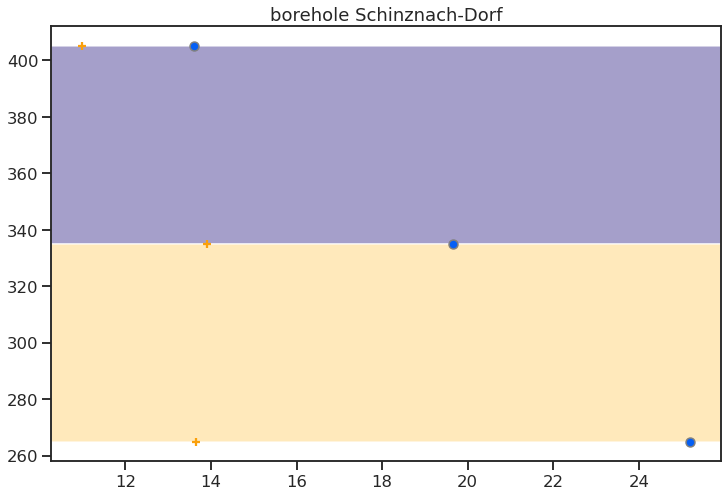

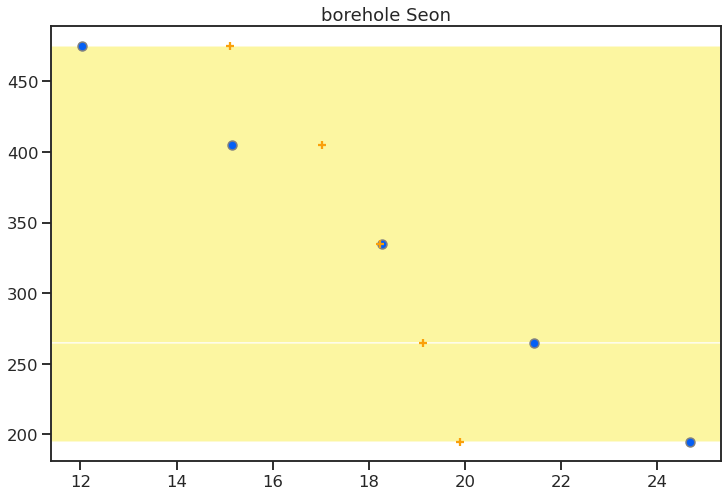

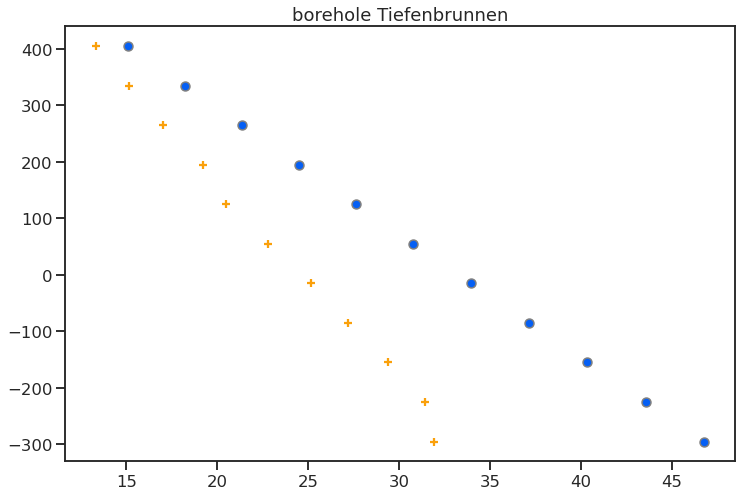

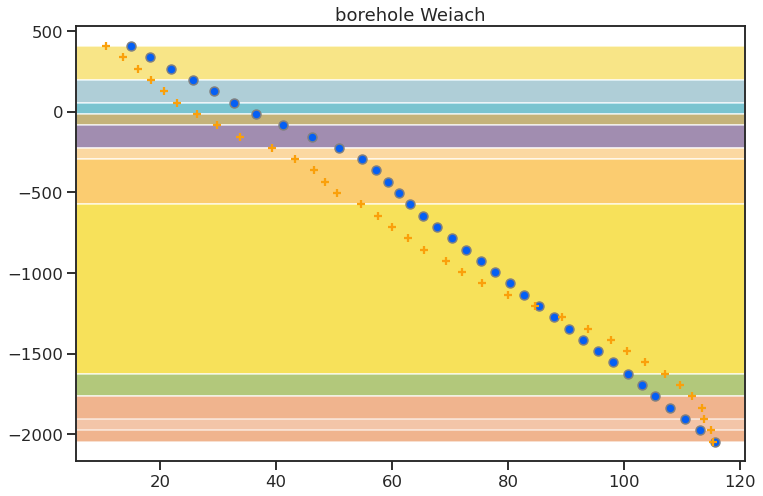

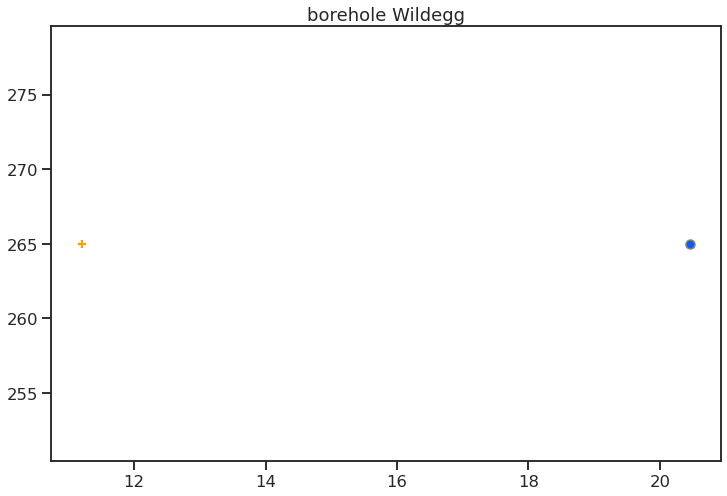

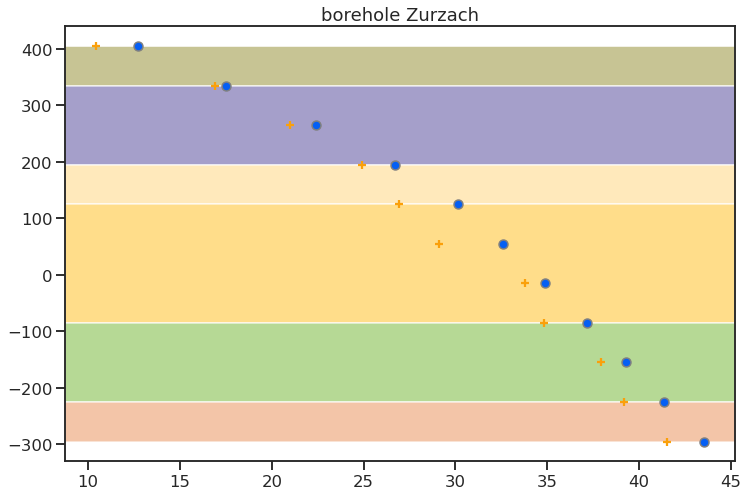

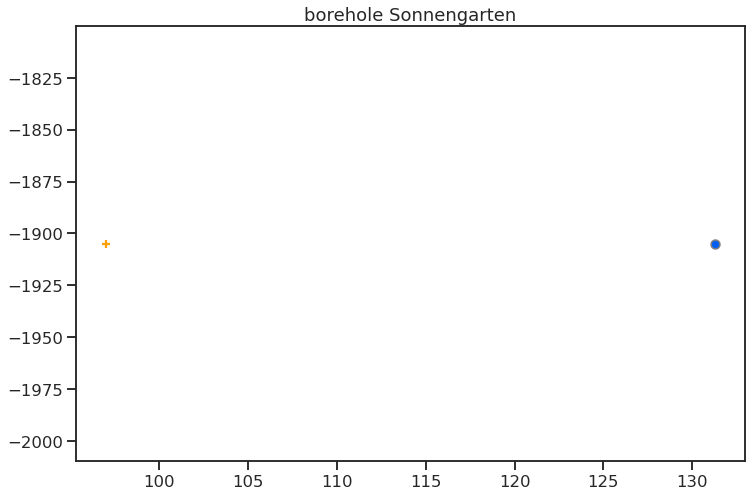

In [60]:
data = load_inv(diff_name)
all_wells = len(unique_bholes)
subplt_x = 3
subplt_y = all_wells // subplt_x

for f in range(all_wells):
    fig = plt.figure(figsize=[12,8])
    plot_logs(sim_obs, 70, borehole=f)
    plt.title(f"borehole {unique_bholes['name'][f]}")

In [50]:
len(axs)

TypeError: object of type 'builtin_function_or_method' has no len()

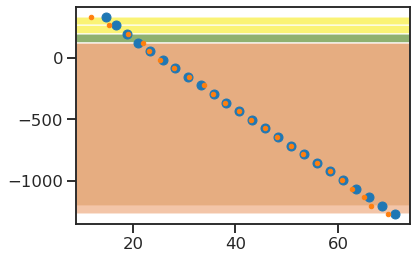

In [28]:
fst = unique_bholes.iloc[15]

get_hole = sim_obs.query(f"i=={fst['i']} and j=={fst['j']}")

litho_changes = np.where(get_hole['unit'].values[:-1] != get_hole['unit'].values[1:])[0]
litho_f_color = list(get_hole['unit'].values[litho_changes])
litho_f_color.append(get_hole['unit'].iloc[-1])

depth = (get_hole['k'].values*delz) - 5965

plt.plot(get_hole['calc'], depth, 'o')
plt.plot(get_hole['obs'], depth, '.')

for l in range(len(depth[litho_changes])):
    try:
        plt.axhspan(depth[litho_changes][l+1], 
                   depth[litho_changes][l], 
                    facecolor=col_dict[litho_f_color[l]], alpha=apa, zorder=-1)
    except IndexError:
        plt.axhspan(depth[0], depth[litho_changes][0],
                   facecolor=col_dict[litho_f_color[0]], alpha=apa, zorder=-1)
        plt.axhspan(depth[-1], depth[litho_changes][l],
                   facecolor=col_dict[litho_f_color[-1]], alpha=apa, zorder=-1)

In [260]:
litho_f_color

[15, 17, 18, 17, 18]

In [261]:
depth[litho_changes]

array([  265.,   195., -1205.,   125.])

In [255]:
get_hole

,i,j,k,unit,type,calc,obs,err,diff,res,time,ozone
87,39,89,90,15,2,14.729222,11.80,0.7,2.929222,4.184603,60000000.0,1
88,39,89,89,15,2,16.714719,15.26,0.7,1.454719,2.078170,60000000.0,1
89,39,89,88,17,2,18.805029,19.03,0.7,-0.224971,-0.321387,60000000.0,1
90,39,89,86,18,2,23.327333,23.20,0.7,0.127333,0.181904,60000000.0,1
91,39,89,85,18,2,25.807698,25.39,0.7,0.417698,0.596711,60000000.0,1
92,39,89,84,18,2,28.286960,28.01,0.7,0.276960,0.395657,60000000.0,1
93,39,89,83,18,2,30.767375,30.99,0.7,-0.222625,-0.318036,60000000.0,1
94,39,89,82,18,2,33.250508,33.90,0.7,-0.649492,-0.927846,60000000.0,1
95,39,89,81,18,2,35.737449,35.55,0.7,0.187449,0.267785,60000000.0,1
96,39,89,80,18,2,38.228962,38.00,0.7,0.228962,0.327088,60000000.0,1


In [251]:
depth

array([335., 265., 195., 125.,  55.])

In [249]:
depth[litho_changes]

array([335., 125.])

In [149]:
i_s = diffs[:,0]
j_s = diffs[:,1]
k_s = diffs[:,2]

calc = diffs[:,5]
obs = diffs[:,6]

In [150]:
ij = diffs[:,:2]
indices = np.unique(ij, axis=0).astype(int)
i_un = indices[:,0]
j_un = indices[:,1]

In [151]:
boreholes_in_data = ij_boreholes.query("i in @i_un and j in @j_un")

In [163]:
len(boreholes_in_data['Nr.'])

27

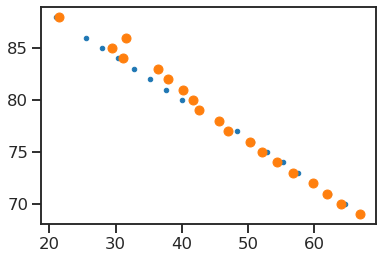

In [43]:
plt.plot(calc[1:20], k_s[1:20], '.')
plt.plot(obs[1:20], k_s[1:20], 'o')

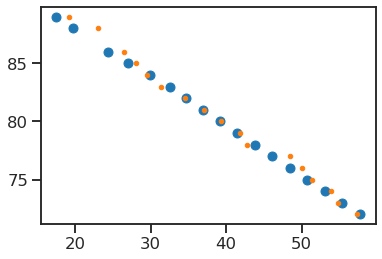

In [57]:
plt.plot(calc[21:38], k_s[21:38], 'o')
plt.plot(obs[21:38], k_s[21:38], '.')

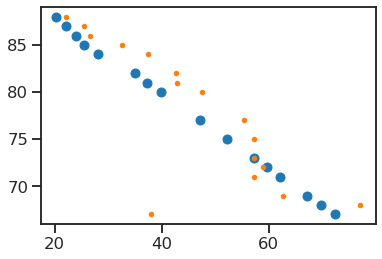

In [69]:
plt.plot(calc[40:56], k_s[40:56], 'o')
plt.plot(obs[40:56], k_s[40:56], '.')

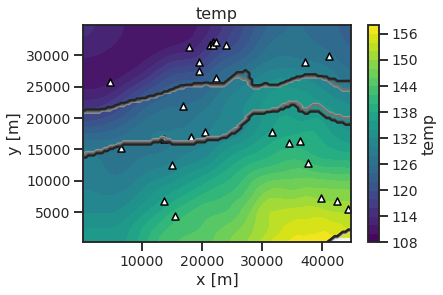

In [155]:
# plot slice
plot_slice(model_path, parameter='temp', direction='z', cell_number=50)
# plot boreholes
plt.scatter(x[boreholes_in_data['i']], y[boreholes_in_data['j']], s=50, marker='^', color='white', edgecolor='black');
#plt.savefig('../../figs/Temperature_map_2p5km_depth_fault_horizon.png', dpi=300, bbox_inches='tight')

## Analysis of Test model

In [2]:
test_mod = h5py.File('../../models/20201020_GeoMol_jordan_erode_SHEMAT-Suite_export/test_AD.txt_final.h5')

In [3]:
x_test = test_mod['x'][0,0,:]
y_test = test_mod['y'][0,:,0]
z_test = test_mod['z'][:,0,0]

temp_test = test_mod['temp'][:,:,:]

In [4]:
temp_test

array([[[12.13166431, 12.13690086, 12.14444491, 12.15194392,
         12.15710642],
        [12.15788307, 12.16313368, 12.17068218, 12.17817025,
         12.18331948],
        [12.19586055, 12.20112334, 12.20867828, 12.21616087,
         12.22129469],
        [12.23381837, 12.23908655, 12.24664189, 12.25411696,
         12.25924301],
        [12.26000285, 12.26527133, 12.27282204, 12.28028739,
         12.28541328]],

       [[12.05122518, 12.05334746, 12.05650157, 12.05950755,
         12.06138445],
        [12.06158347, 12.06380797, 12.06698391, 12.06991142,
         12.07171405],
        [12.07766318, 12.07995008, 12.08316293, 12.08609608,
         12.08780307],
        [12.09367243, 12.09598299, 12.09919928, 12.10210655,
         12.10378669],
        [12.1038936 , 12.10620446, 12.10939359, 12.11223025,
         12.11394713]],

       [[11.94272472, 11.94395708, 11.94532825, 11.94622631,
         11.94666824],
        [11.94743052, 11.94958357, 11.95105414, 11.95120562,
         11

## model DEM

In [58]:
dem = pd.read_csv('/home/bl2/ETHeatflow/QGIS/new_model_dtm_xyz.csv', header=None)

In [59]:
dem = dem[dem[2] != -9999.0]

In [60]:
dem.columns = ['x', 'y', 'z']

In [18]:
dem.to_csv('../../data/processed/GemPy/06_DTMs/Model_DTM_xyz.csv', index=False)

In [45]:
dem = pd.read_csv('../../data/processed/GemPy/06_DTMs/Model_DTM_xyz.csv')

In [46]:
zs = dem['z'].values

In [47]:
zs = np.fliplr(zs.reshape((100,100), order='F'))

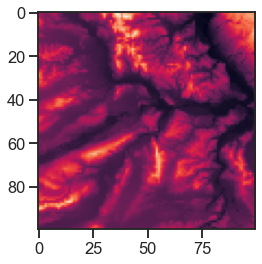

In [48]:
plt.imshow(zs)

In [49]:
zs[:,0].shape

(100,)

In [33]:
liths = np.loadtxt('../../models/20201005_GeoMol_jordan_erode_mesozoic/PCT_erode_final_fine_w_boreholes/lith_grid')

In [34]:
liths3D = liths.reshape((100,100,100), order='F')

liths3D[X,Y,Z]

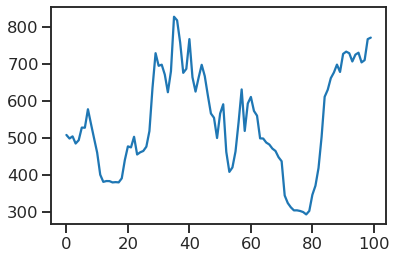

In [108]:
plt.plot(zs[0,:])

In [171]:
zs[50,99]

345.901

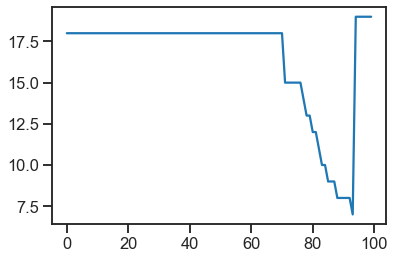

In [35]:
plt.plot(liths3D[0,0,:])

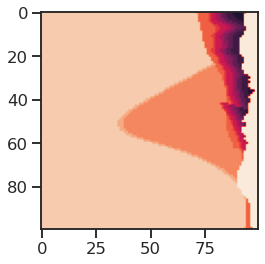

In [104]:
plt.imshow(liths3D[0,:,:])

In [37]:
ijk = np.where(liths3D[:,:,:]==19)

In [38]:
s=np.stack([ijk[0],ijk[1],ijk[2]], axis=1)

In [39]:
s1 = s.copy()

In [40]:
s1[:,2] = s1[:,2] - 1

In [41]:
s2 = np.append(s, s1, axis=0)

In [42]:
s2.shape

(151858, 3)

In [43]:
new_array = [tuple(row) for row in s2]
s3 = np.unique(new_array, axis=0)

In [50]:
zs[s[0,:2][0], s[0,:2][1]]

507.897

In [258]:
height = np.zeros(len(s3))

for i in range(len(s3)):
    indices = s3[i,:2]
    height[i] = zs[indices[0], indices[1]]
    
    

In [259]:
hresh = height.reshape(-1,1)

In [260]:
ijkh = np.append(s3, hresh, axis=1)

In [263]:
direction = np.zeros_like(hresh)

In [261]:
ijkh[:,:3] = ijkh[:,:3] + 1

In [262]:
ijkh[:,3] = ijkh[:,3] + 6000

In [264]:
ijkh_d = np.append(ijkh, direction, axis=1)

In [265]:
ijkh

array([[1.000000e+00, 1.000000e+00, 9.400000e+01, 6.507897e+03],
       [1.000000e+00, 1.000000e+00, 9.500000e+01, 6.507897e+03],
       [1.000000e+00, 1.000000e+00, 9.600000e+01, 6.507897e+03],
       ...,
       [1.000000e+02, 1.000000e+02, 9.800000e+01, 6.477799e+03],
       [1.000000e+02, 1.000000e+02, 9.900000e+01, 6.477799e+03],
       [1.000000e+02, 1.000000e+02, 1.000000e+02, 6.477799e+03]])

In [267]:
len(ijkh)

85929

In [266]:
np.savetxt('../../data/processed/GemPy/06_DTMs/Model_DTM_z_vals_SHEMAT_head_bc_new.txt', ijkh_d, fmt='%d, %d, %d, %.3f, %d')

## model surface temperatures

In [11]:
stemps = pd.read_csv('../../data/processed/temperature_data/Surface_temperatures/surface_temperatures_xyz.csv')
stemps.head()

,x,y,t
0,2640225.0,1274825.0,7.1
1,2640675.0,1274825.0,7.3
2,2641125.0,1274825.0,7.3
3,2641575.0,1274825.0,7.6
4,2642025.0,1274825.0,7.6


In [25]:
for i,j in stemps.query("t<0").iterrows():
    stemps['t'].iloc[i] = stemps['t'].iloc[i-1]

In [27]:
stemps.to_csv('../../data/processed/temperature_data/Surface_temperatures/surface_temperatures_xyz_no_Null.csv', index=False)

In [28]:
stemps.shape

(10000, 3)

In [31]:
st_resh = np.fliplr(stemps['t'].values.reshape((100,100), order='F'))

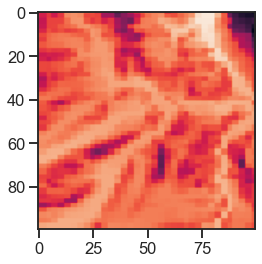

In [51]:
plt.imshow(st_resh)

In [55]:
temp_bc = np.zeros(len(s3))

for i in range(len(s3)):
    indices = s3[i,:2]
    temp_bc[i] = st_resh[indices[0], indices[1]]

In [56]:
tbc_resh = temp_bc.reshape(-1,1)

In [57]:
ijkt = np.append(s3, tbc_resh, axis=1)

In [61]:
direction = np.zeros_like(tbc_resh)
ijkt[:,:3] = ijkt[:,:3] + 1

In [62]:
ijkt_d = np.append(ijkt, direction, axis=1)

In [63]:
np.savetxt('../../data/processed/temperature_data/Surface_temperatures/Model_SHEMAT_temp_bcd_top.txt', ijkt_d, fmt='%d, %d, %d, %.3f, %d')